In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier
import shap

> 클러스터

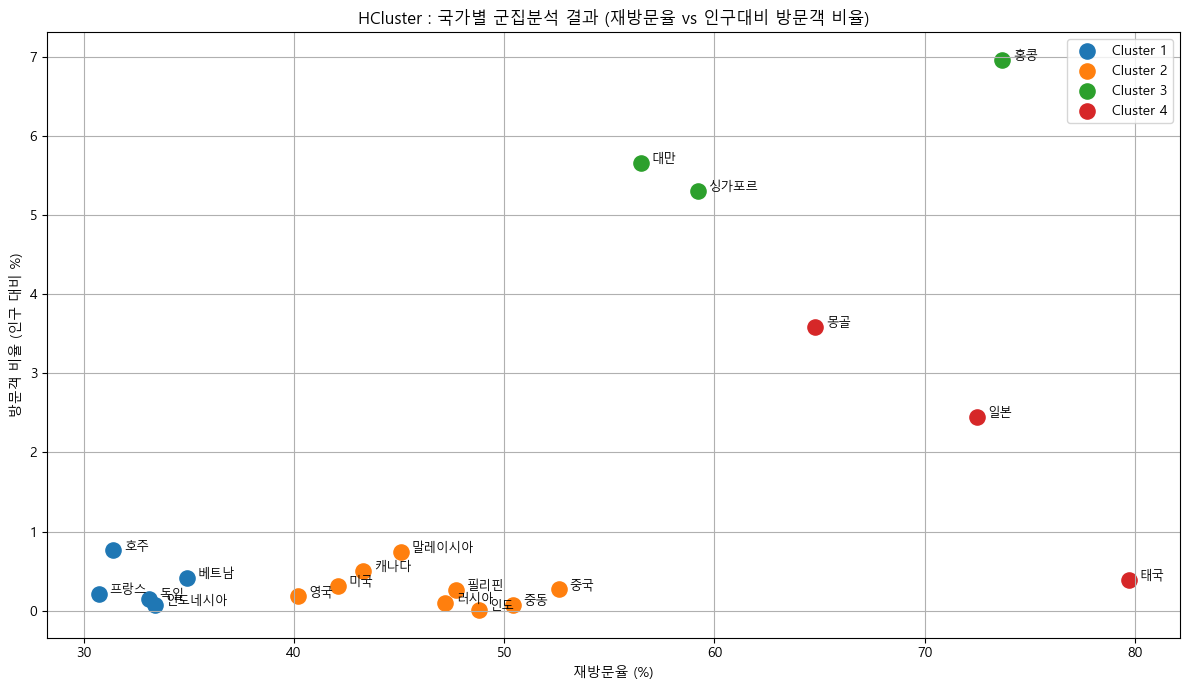

> 체재기간과 1일 평균 소비금액 사이에 강한 상관관계가 존재하는가?

In [2]:
import pandas as pd

# 데이터 불러오기
df = pd.read_excel("../data/2024 외래관광객조사_Data.xlsx")

# 사용할 컬럼만 선택
cols = ['M일HAP', '총액1인TOT2', '총액1인TOT_개별국제교통비제외2']
df_subset = df[cols].copy()

# 결측치 제거
df_subset = df_subset.dropna()

# 총 체재일수가 0일인 경우 제외 (0으로 나눌 수 없음)
df_subset = df_subset[df_subset['M일HAP'] > 0]

# 1일 평균 지출 계산 (국제교통비 제외)
df_subset['1일평균지출'] = df_subset['총액1인TOT_개별국제교통비제외2'] / df_subset['M일HAP']

# 상관계수 행렬 계산 (피어슨)
correlation_matrix = df_subset[['M일HAP', '총액1인TOT2', '총액1인TOT_개별국제교통비제외2', '1일평균지출']].corr(method='pearson')

# 출력
print("상관계수 행렬 (피어슨):")
print(correlation_matrix)


상관계수 행렬 (피어슨):
                       M일HAP  총액1인TOT2  총액1인TOT_개별국제교통비제외2    1일평균지출
M일HAP               1.000000  0.315437            0.336666 -0.231266
총액1인TOT2            0.315437  1.000000            0.881739  0.480167
총액1인TOT_개별국제교통비제외2  0.336666  0.881739            1.000000  0.594946
1일평균지출             -0.231266  0.480167            0.594946  1.000000


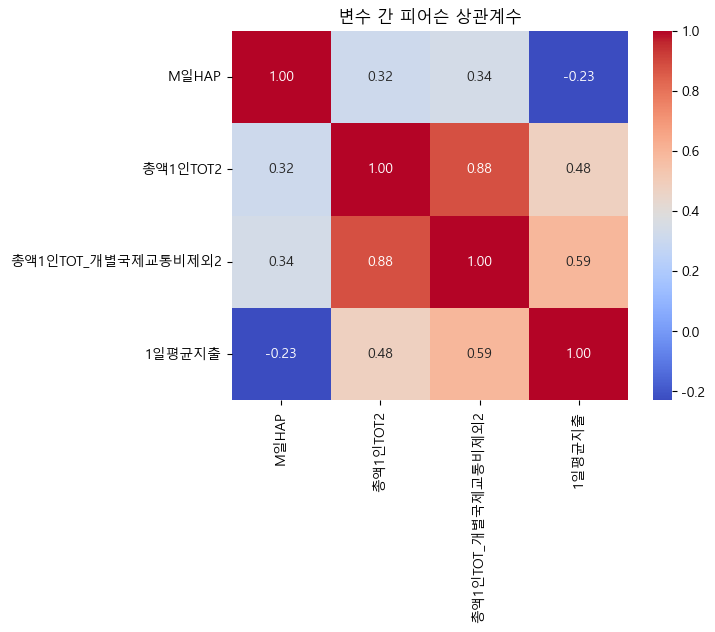

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("변수 간 피어슨 상관계수")
plt.show()


상관계수 (피어슨):
                       M일HAP  총액1인TOT_개별국제교통비제외2    1일평균지출
M일HAP               1.000000            0.336666 -0.231266
총액1인TOT_개별국제교통비제외2  0.336666            1.000000  0.594946
1일평균지출             -0.231266            0.594946  1.000000


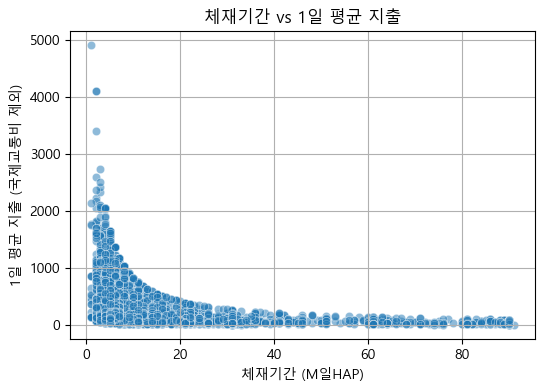

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 분석에 사용할 변수 선택
cols = ['M일HAP', '총액1인TOT2', '총액1인TOT_개별국제교통비제외2']
df_subset = df[cols].copy()

# 3. 결측치 제거 + 체재기간 0일 제거
df_subset = df_subset.dropna()
df_subset = df_subset[df_subset['M일HAP'] > 0]

# 4. 1일 평균 지출 변수 생성
df_subset['1일평균지출'] = df_subset['총액1인TOT_개별국제교통비제외2'] / df_subset['M일HAP']

# 5. 상관계수 확인
correlation_matrix = df_subset[['M일HAP', '총액1인TOT_개별국제교통비제외2', '1일평균지출']].corr(method='pearson')
print("상관계수 (피어슨):")
print(correlation_matrix)

# # 6. 시각화: 상관계수 히트맵
# plt.figure(figsize=(6, 4))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title("체재기간, 총지출, 1일평균지출 간 상관관계")
# plt.show()

# 7. 시각화: 산점도 (체재기간 vs 1일 평균 지출)
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_subset, x='M일HAP', y='1일평균지출', alpha=0.5)
plt.title("체재기간 vs 1일 평균 지출")
plt.xlabel("체재기간 (M일HAP)")
plt.ylabel("1일 평균 지출 (국제교통비 제외)")
plt.grid(True)
plt.show()


In [5]:
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
df = pd.read_excel("../data/2024 외래관광객조사_Data.xlsx")

# 2. 변수 선택 및 결측 제거
df_subset = df[['M일HAP', '총액1인TOT_개별국제교통비제외2', 'weight']].dropna()
df_subset = df_subset[df_subset['M일HAP'] > 0]
df_subset['1일평균지출'] = df_subset['총액1인TOT_개별국제교통비제외2'] / df_subset['M일HAP']

# 3. 가중치 기반 피어슨 상관계수 함수
def weighted_corr(x, y, w):
    """가중치 기반 피어슨 상관계수"""
    x_bar = np.average(x, weights=w)
    y_bar = np.average(y, weights=w)
    cov_xy = np.average((x - x_bar) * (y - y_bar), weights=w)
    std_x = np.sqrt(np.average((x - x_bar)**2, weights=w))
    std_y = np.sqrt(np.average((y - y_bar)**2, weights=w))
    return cov_xy / (std_x * std_y)

# 4. 상관계수 계산
r = weighted_corr(df_subset['M일HAP'], df_subset['1일평균지출'], df_subset['weight'])
print(f"가중치 기반 피어슨 상관계수 (체재기간 vs 1일 평균 지출): {r:.3f}")


가중치 기반 피어슨 상관계수 (체재기간 vs 1일 평균 지출): -0.207


> 클러스터별 추천 종속변수

| 클러스터               | 포함 국가                         | 특성 요약                 | 추천 종속변수                               | 변수명                                                     |
| ------------------ | ----------------------------- | --------------------- | ------------------------------------- | ------------------------------------------------------- |
| **Cluster 1 (파랑)** | 호주, 프랑스, 독일, 베트남, 인도네시아       | 방문 비율/재방문율 낮음 → 신규시장  | **재방문 가능성**, **만족도**                  | `재방문여부`, `재방문의사`, `만족도`                                 |
| **Cluster 2 (주황)** | 미국, 중국, 필리핀, 말레이시아, 캐나다, 인도 등 | 방문도 재방문도 중간 → 안정시장    | **총 소비**, **1일 지출**, **추천의향**         | `1인 총소비_국제교통비 포함`, `1인 체류일별 소비금액`, `재방문의사`              |
| **Cluster 3 (초록)** | 홍콩, 대만, 싱가포르                  | 방문율·재방문율 모두 높음 → VIP층 | **1일 지출**, **항목별 소비성향**               | `1인 체류일별 소비금액`, `쇼핑장소_면세점`, `만족활동_쇼핑`, `만족활동_한류`        |
| **Cluster 4 (빨강)** | 일본, 태국, 몽골                    | 재방문율 매우 높음 → 소비 확대 대상 | **1인 총 소비**, **소비 항목별 지출**, **활동 참여** | `1인 총소비_국제교통비 포함`, `만족활동_미식`, `만족활동_전통문화`, `만족활동_오락/유흥` |


> 종속변수가 재방문 여부일 때, 설명변수 제외할 것

In [6]:
df = pd.read_csv('../data/최종모델링데이터_Final.csv')

In [7]:
# 경험 선택자 중 재방문자 비율
n_experience = df[df["Q1_관심계기_경험"] == True].shape[0]
n_experience_and_revisit = df[(df["Q1_관심계기_경험"] == True) & (df["재방문여부"] == True)].shape[0]
p_revisit_given_experience = n_experience_and_revisit / n_experience

# 새로움 선택자 중 비재방문자 비율
n_newness = df[df["Q1_관심계기_새로움"] == True].shape[0]
n_newness_and_nonrevisit = df[(df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == False)].shape[0]
p_nonrevisit_given_newness = n_newness_and_nonrevisit / n_newness

print(f"P(재방문자 | '경험') = {p_revisit_given_experience:.3%}")
print(f"P(비재방문자 | '새로움') = {p_nonrevisit_given_newness:.3%}")


P(재방문자 | '경험') = 100.000%
P(비재방문자 | '새로움') = 99.964%


In [8]:
# 새로움을 선택했지만 재방문자인 사람
mask = (df["Q1_관심계기_새로움"] == True) & (df["재방문여부"] == True)
df_exception = df[mask]

print(f"예외 행 수: {df_exception.shape[0]}")
df_exception

예외 행 수: 1


,재방문여부,여행형태_개별여행,여행형태_에어텔,여행형태_단체여행,Q1_응답대상,Q1_관심계기_경제성,Q1_관심계기_경험,Q1_관심계기_기타,Q1_관심계기_문화콘텐츠,Q1_관심계기_새로움,...,월_7,월_8,월_9,월_10,월_11,월_12,분기_1,분기_2,분기_3,분기_4
13076,1,True,False,False,1,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True


# Cluster 1

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [9]:
# 클러스터 국가 리스트
cluster1_countries = [
    '국가_프랑스', '국가_베트남', '국가_인도네시아', '국가_호주', '국가_독일'
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster1_mask = df[cluster1_countries].any(axis=1)
df_c1 = df[cluster1_mask].copy()

In [10]:
# 종속변수
y = df_c1["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c1.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c1["가중치"]

In [11]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [12]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [13]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.269]
Accuracy     : 0.666
Precision    : 0.500
Recall       : 0.709
F1 Score     : 0.587
ROC AUC      : 0.719

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.815     0.644     0.719 222283.84999999998
           1      0.500     0.709     0.587 111862.34999999999

    accuracy                          0.666 334146.19999999995
   macro avg      0.657     0.676     0.653 334146.19999999995
weighted avg      0.709     0.666     0.675 334146.19999999995


▶ [혼동 행렬]
[[351 191]
 [ 75 196]]


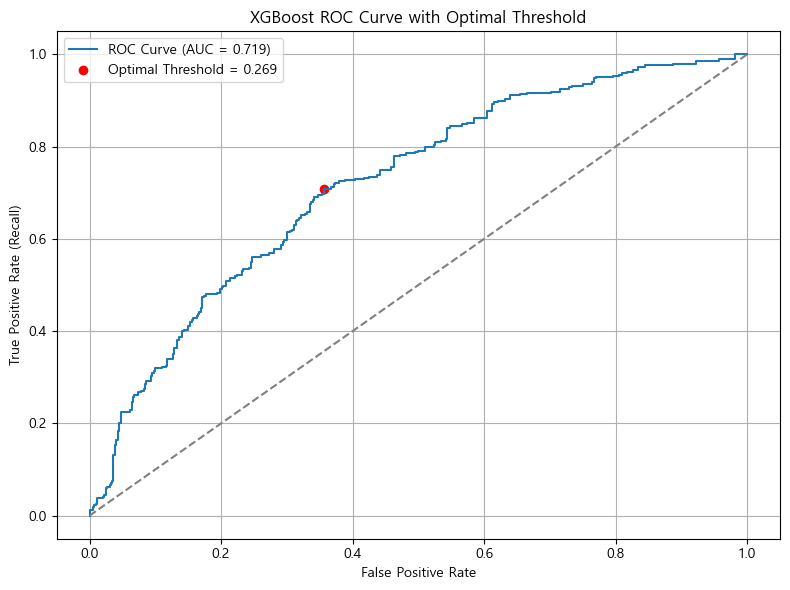

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

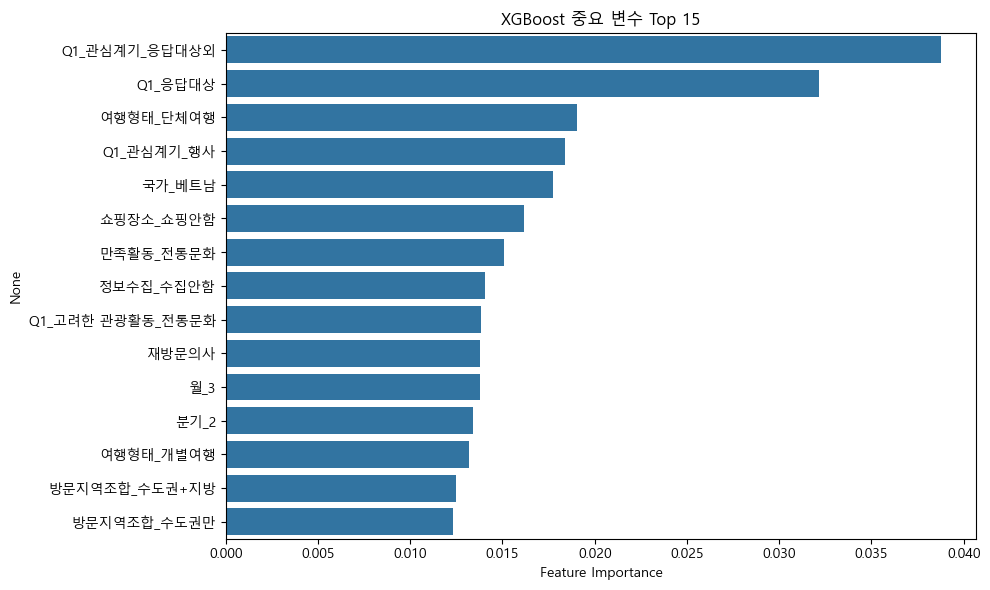

In [15]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

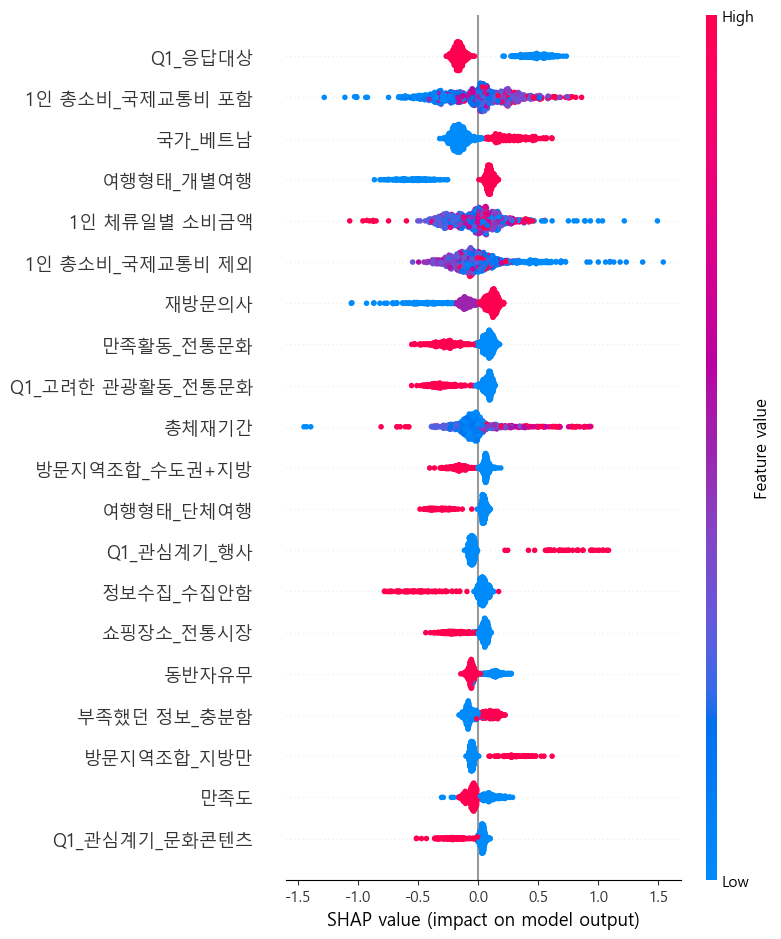

In [16]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [17]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7313657398871307, 0.7812658035834892, 0.7330899282986696, 0.7036613735147098, 0.7366575787770739]
▶ Mean AUC: 0.7372080848122147
▶ Std AUC : 0.02497142241201045


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [18]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7230857556025402


In [19]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.6, 'subsample': 1.0}
Best AUC Score: 0.7275243395490407


In [20]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.1, 'n_estimators': 100}
Best AUC Score: 0.7275243395490407


In [21]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best AUC Score: 0.727953428008556


In [22]:
best_model = grid_search_4.best_estimator_

In [23]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [24]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 1.0
colsample_bytree = 0.6
learning_rate    = 0.1
n_estimators     = 100
gamma            = 0.5
reg_alpha        = 0.1
reg_lambda       = 0.5


In [25]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.328]
Accuracy     : 0.694
Precision    : 0.534
Recall       : 0.667
F1 Score     : 0.593
ROC AUC      : 0.735

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.808     0.708     0.755 222283.84999999998
           1      0.534     0.667     0.593 111862.34999999999

    accuracy                          0.694 334146.19999999995
   macro avg      0.671     0.687     0.674 334146.19999999995
weighted avg      0.717     0.694     0.701 334146.19999999995


▶ [혼동 행렬]
[[387 155]
 [ 89 182]]


클래스별 개수:
재방문여부
0    1807
1     902
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
0    66.7
1    33.3
Name: proportion, dtype: float64


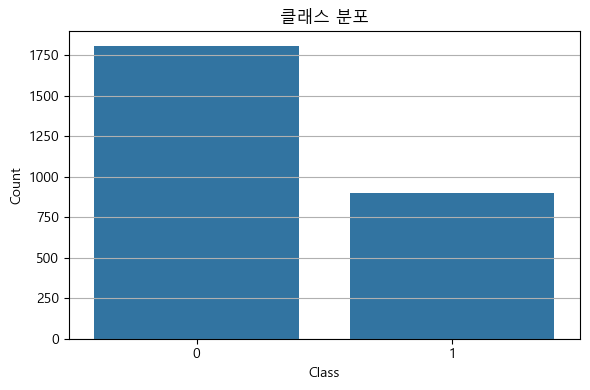

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

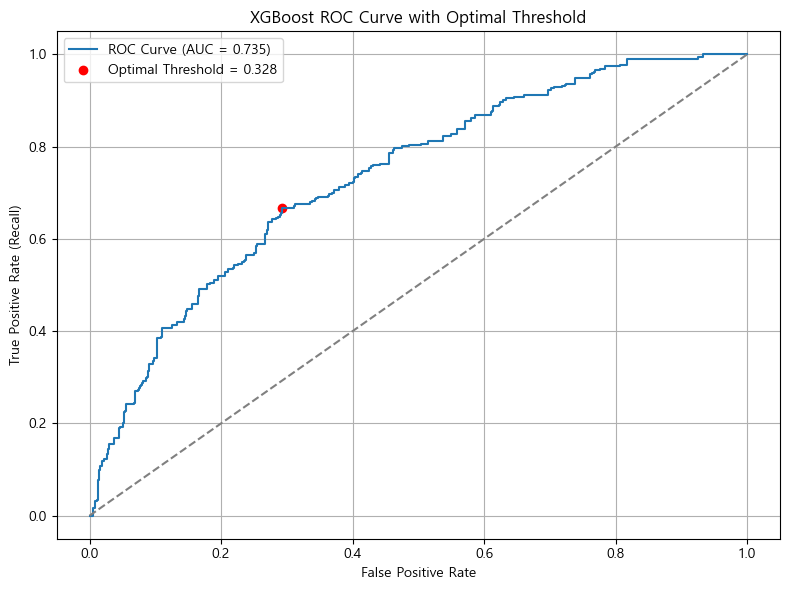

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

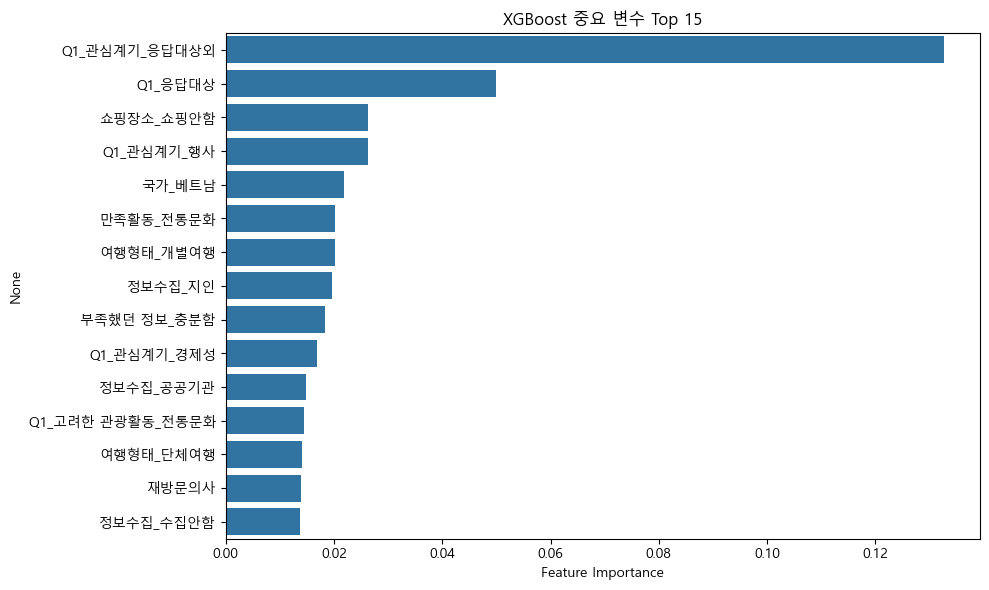

In [28]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

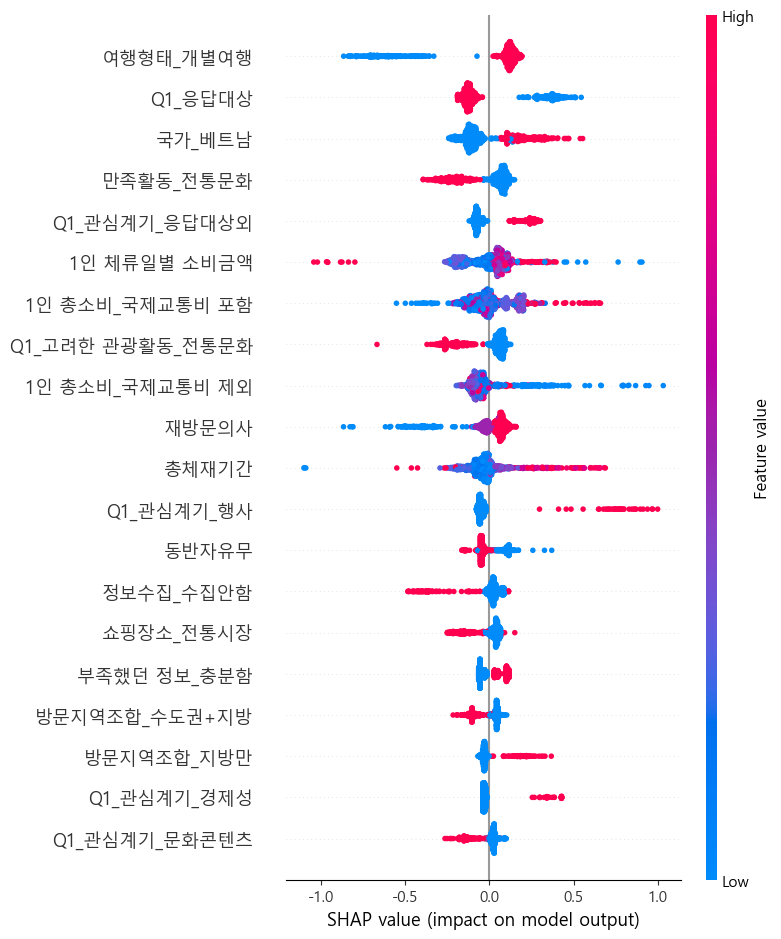

In [29]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [30]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [31]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.7370028  0.7654612  0.72995703 0.72760896 0.75070791]
▶ Mean AUC: 0.7421475796207588
▶ Std AUC: 0.014165123550069852


### Cluster1 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

In [32]:
# ─────────── 기본 모델 기반 시뮬레이션 ───────────
# 조건부 타깃
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
proba_before = model.predict_proba(X_target)[:, 1]

# 단일 선택형 변수 처리
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
# 고려한 관광활동 변수 리스트
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]


# 변수 개입 시나리오 적용
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before #delta = After - Before는 정책 개입의 기대 효과 (확률 기준 변화량)
summary_model = pd.DataFrame({'Before': proba_before, 'After': proba_after, 'Change': delta})

#개입 후 예측 확률이 optimal_threshold를 넘으면 재방문 가능성 상승자로 간주
#“정책 개입 시 얼마나 많은 사람들이 재방문자로 바뀔 가능성이 있는가”를 판단
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# 분석 요약 출력
print("\n[기본 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_model)}")
print(f"▶ 평균 확률 변화        : {delta.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_model['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_model['Lifted'].mean() * 100:.2f}%")
# 예를 들어 재방문 확률 0.25였는데, 변수 조작 후에는 0.88로 상승
print(f"▶ 최대 변화             : {delta.max():.4f}")
# -이면 오히려 감소한 경우
print(f"▶ 최소 변화             : {delta.min():.4f}")



[기본 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 94
▶ 평균 확률 변화        : 0.2760
▶ 재방문 확률 상승자 수 : 65명
▶ 상승 비율             : 69.15%
▶ 최대 변화             : 0.6678
▶ 최소 변화             : -0.0306


In [33]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
# 조건부 타깃 재사용
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 94
▶ 평균 확률 변화        : 0.2935
▶ 재방문 확률 상승자 수 : 81명
▶ 상승 비율             : 86.17%
▶ 최대 변화             : 0.5383
▶ 최소 변화             : -0.0343


### (4) 시뮬레이션 - 전체 비재방문객에 대해

In [34]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
X_all = X_test.copy()
non_repeat_mask = (y_test == 0)
X_non_repeat = X_all[non_repeat_mask].copy()
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# 단일선택형 변수 그룹
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# 변수 개입
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True
X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True
X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델]")
print(f"▶ 전체 대상 수           : {len(summary_all)}")
print(f"▶ 평균 확률 변화         : {delta_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델]
▶ 전체 대상 수           : 542
▶ 평균 확률 변화         : 0.1216
▶ 재방문 가능성 상승자 수 : 292명
▶ 상승 비율               : 53.87%
▶ 최대 변화               : 0.6678
▶ 최소 변화               : -0.3926


In [35]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True
X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True
X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 542
▶ 평균 확률 변화         : 0.1219
▶ 재방문 가능성 상승자 수 : 362명
▶ 상승 비율               : 66.79%
▶ 최대 변화               : 0.5552
▶ 최소 변화               : -0.1988


# Cluster 2

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [218]:
# 클러스터 국가 리스트
cluster2_countries = [
    '국가_미국', '국가_중국', '국가_필리핀', '국가_말레이시아',
    '국가_인도', '국가_중동', '국가_캐나다', '국가_러시아', '국가_영국'
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster2_mask = df[cluster2_countries].any(axis=1)
df_c2 = df[cluster2_mask].copy()

In [219]:
# 종속변수
y = df_c2["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

In [220]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [221]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [222]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.474]
Accuracy     : 0.696
Precision    : 0.699
Recall       : 0.698
F1 Score     : 0.698
ROC AUC      : 0.754

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.694     0.695     0.694 890054.329999999
           1      0.699     0.698     0.698 904245.7800000005

    accuracy                          0.696 1794300.1099999994
   macro avg      0.696     0.696     0.696 1794300.1099999994
weighted avg      0.696     0.696     0.696 1794300.1099999994


▶ [혼동 행렬]
[[773 338]
 [302 689]]


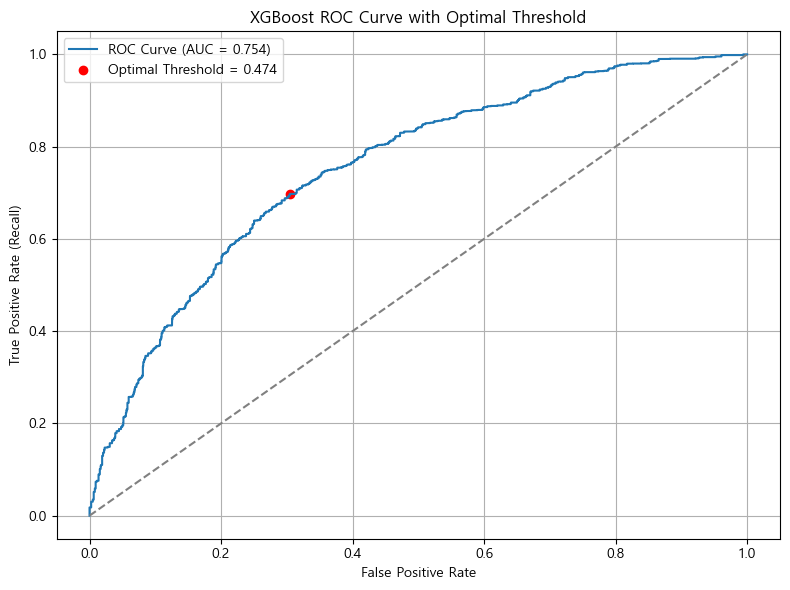

In [223]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

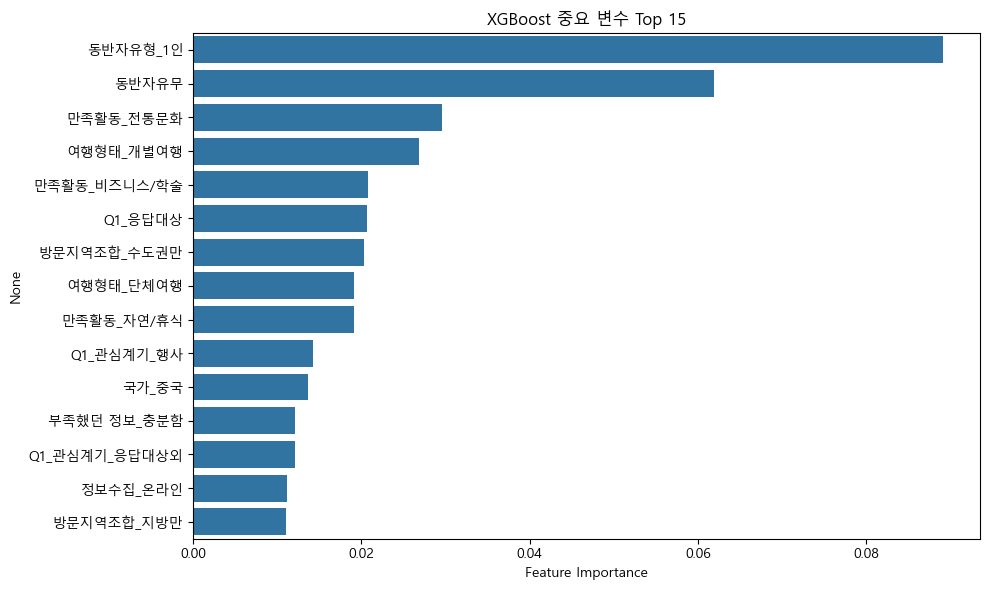

In [224]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

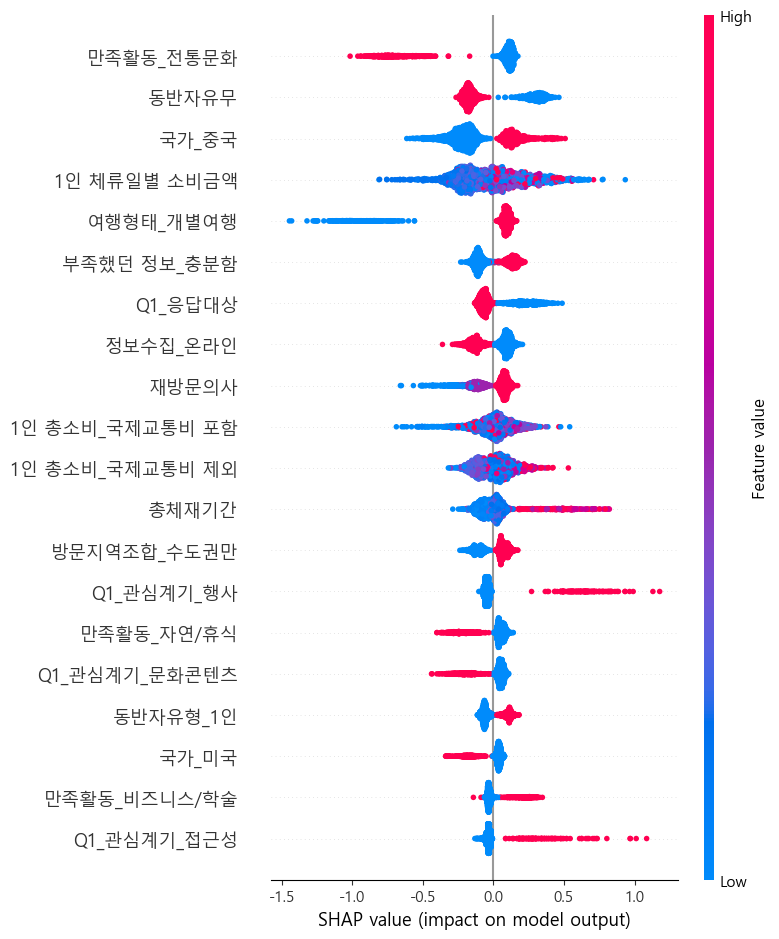

In [225]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [226]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7695200464038219, 0.757926676237779, 0.7662236281347683, 0.7851873887145149, 0.7556392500015204]
▶ Mean AUC: 0.7668993978984809
▶ Std AUC : 0.01047927226587123


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [227]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7596854722023556


In [228]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.8, 'subsample': 0.8}
Best AUC Score: 0.7657889428419878


In [229]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.1, 'n_estimators': 100}
Best AUC Score: 0.7657889428419878


In [230]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best AUC Score: 0.7657992416718642


In [231]:
best_model = grid_search_4.best_estimator_

In [232]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [233]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.8
colsample_bytree = 0.8
learning_rate    = 0.1
n_estimators     = 100
gamma            = 0
reg_alpha        = 0.1
reg_lambda       = 0.5


In [234]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.411]
Accuracy     : 0.693
Precision    : 0.666
Recall       : 0.782
F1 Score     : 0.720
ROC AUC      : 0.759

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.731     0.602     0.660 890054.329999999
           1      0.666     0.782     0.720 904245.7800000005

    accuracy                          0.693 1794300.1099999994
   macro avg      0.699     0.692     0.690 1794300.1099999994
weighted avg      0.698     0.693     0.690 1794300.1099999994


▶ [혼동 행렬]
[[646 465]
 [231 760]]


클래스별 개수:
재방문여부
0    3702
1    3303
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
0    52.85
1    47.15
Name: proportion, dtype: float64


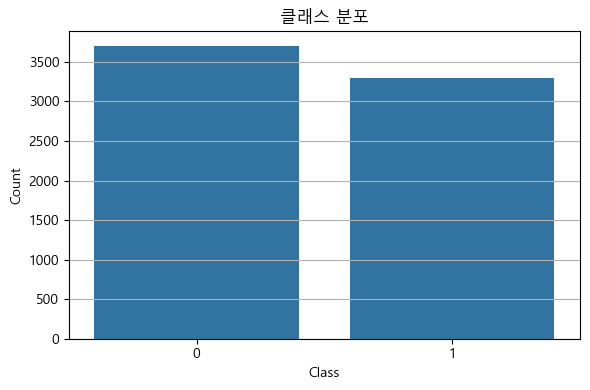

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

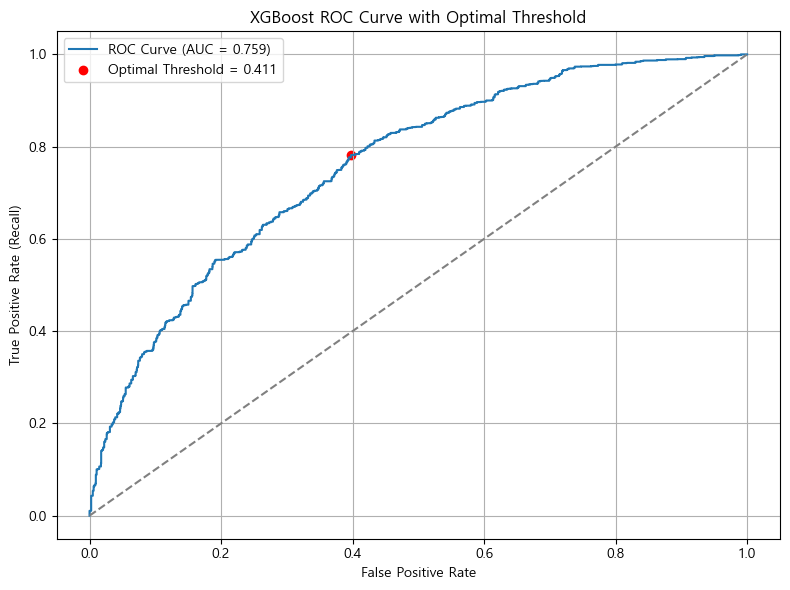

In [236]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

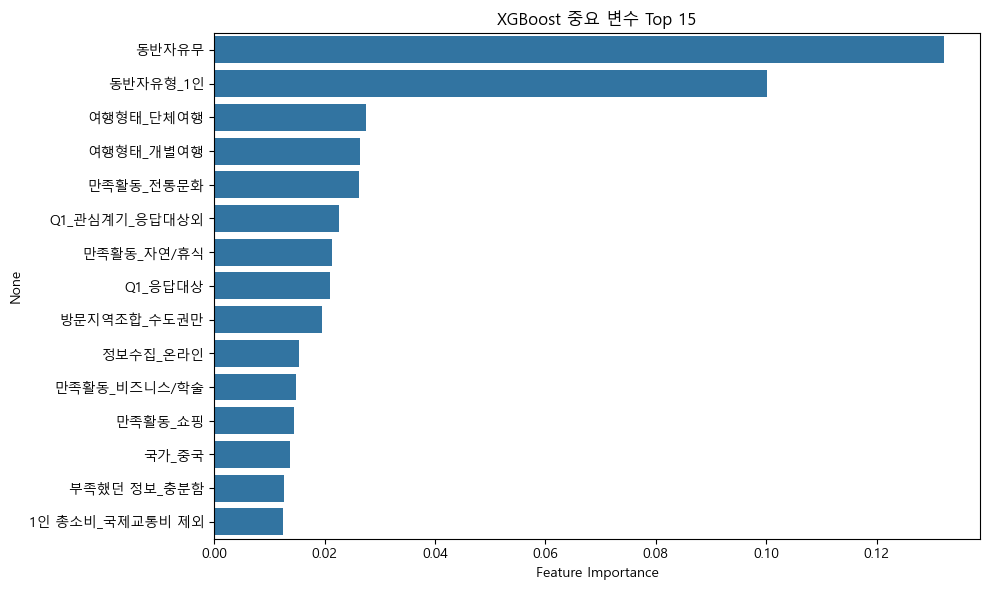

In [237]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

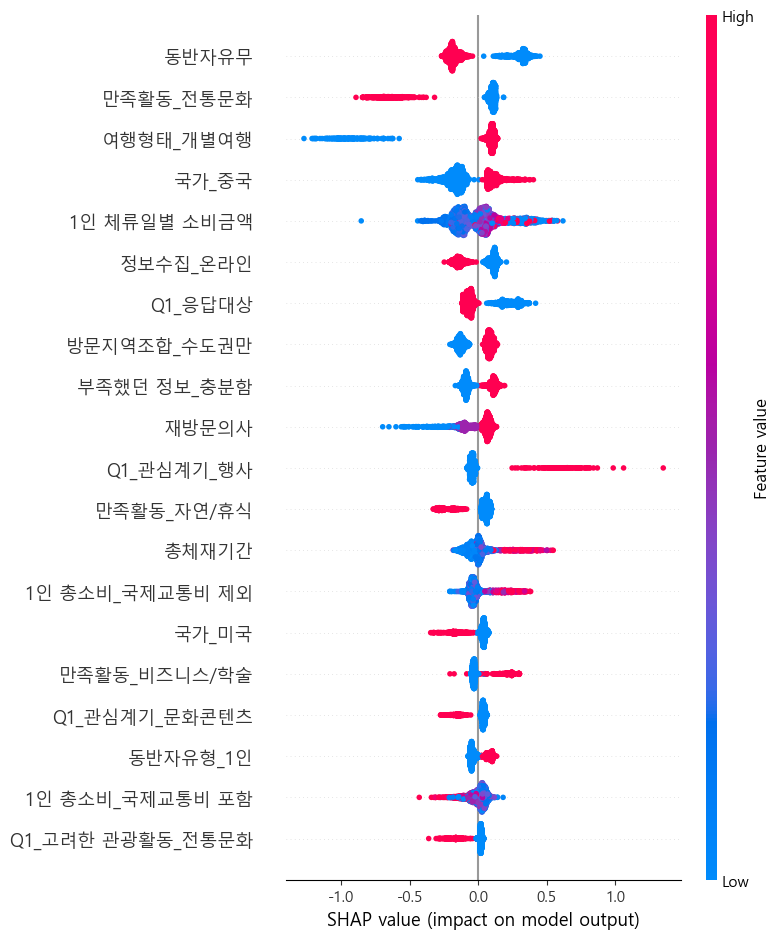

In [238]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [239]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [240]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.75530201 0.76918374 0.75458151 0.77489062 0.769291  ]
▶ Mean AUC: 0.7646497766937292
▶ Std AUC: 0.008194187109150505


### Cluster2 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

In [179]:
# ─────────── 기본 모델 기반 시뮬레이션 ───────────
# 조건부 타깃
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
proba_before = model.predict_proba(X_target)[:, 1]

# 단일 선택형 변수 처리
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
# 고려한 관광활동 변수 리스트
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]


# 변수 개입 시나리오 적용
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before #delta = After - Before는 정책 개입의 기대 효과 (확률 기준 변화량)
summary_model = pd.DataFrame({'Before': proba_before, 'After': proba_after, 'Change': delta})

#개입 후 예측 확률이 optimal_threshold를 넘으면 재방문 가능성 상승자로 간주
#“정책 개입 시 얼마나 많은 사람들이 재방문자로 바뀔 가능성이 있는가”를 판단
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# 분석 요약 출력
print("\n[기본 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_model)}")
print(f"▶ 평균 확률 변화        : {delta.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_model['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_model['Lifted'].mean() * 100:.2f}%")
# 예를 들어 재방문 확률 0.25였는데, 변수 조작 후에는 0.88로 상승
print(f"▶ 최대 변화             : {delta.max():.4f}")
# -이면 오히려 감소한 경우
print(f"▶ 최소 변화             : {delta.min():.4f}")



[기본 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 130
▶ 평균 확률 변화        : 0.3077
▶ 재방문 확률 상승자 수 : 84명
▶ 상승 비율             : 64.62%
▶ 최대 변화             : 0.5971
▶ 최소 변화             : 0.0086


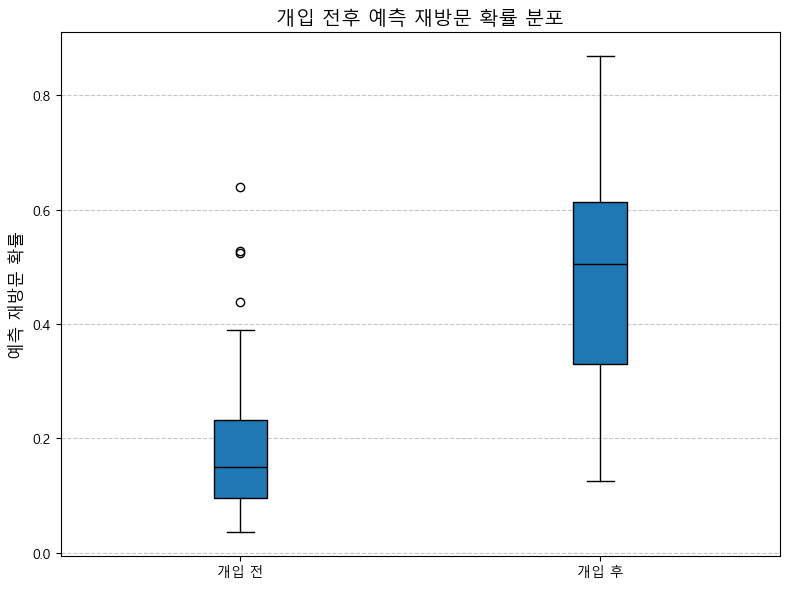

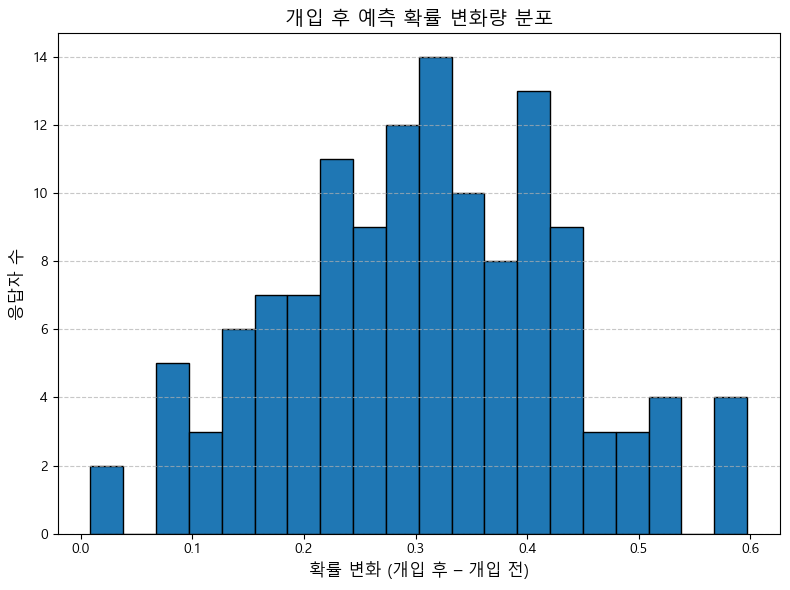

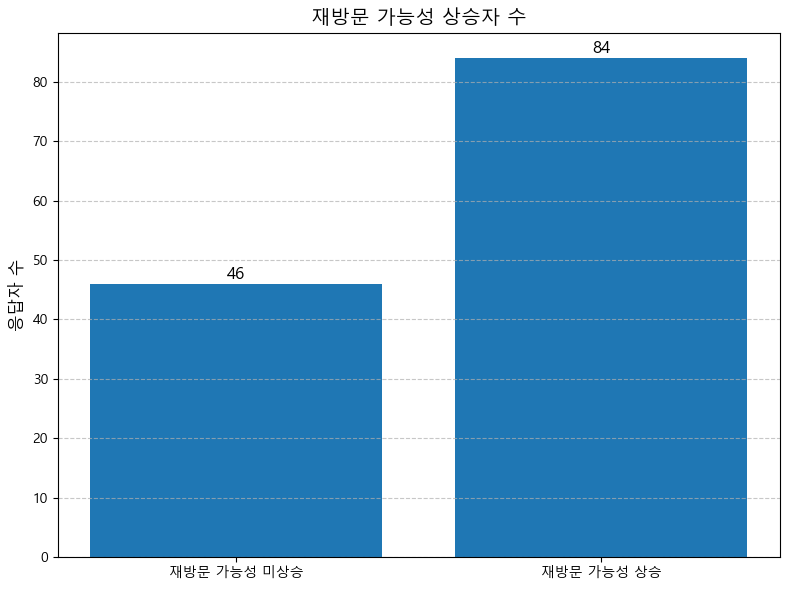

In [247]:
# 1) 개입 전후 예측 확률 분포 (Boxplot)
plt.figure(figsize=(8, 6))
plt.boxplot(
    [summary_model['Before'], summary_model['After']],
    labels=['개입 전', '개입 후'],
    patch_artist=True,
    medianprops={'color': 'black'}
)
plt.title('개입 전후 예측 재방문 확률 분포', fontsize=14)
plt.ylabel('예측 재방문 확률', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2) 개입 후 확률 변화량 분포 (Histogram)
plt.figure(figsize=(8, 6))
plt.hist(summary_model['Change'], bins=20, edgecolor='black')
plt.title('개입 후 예측 확률 변화량 분포', fontsize=14)
plt.xlabel('확률 변화 (개입 후 – 개입 전)', fontsize=12)
plt.ylabel('응답자 수', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3) 재방문 가능성 상승자 비율 (Bar Chart)
lift_counts = summary_model['Lifted'].value_counts().sort_index()
labels = ['재방문 가능성 미상승', '재방문 가능성 상승']

plt.figure(figsize=(8, 6))
plt.bar(labels, lift_counts.values)
plt.title('재방문 가능성 상승자 수', fontsize=14)
plt.ylabel('응답자 수', fontsize=12)
for i, v in enumerate(lift_counts.values):
    plt.text(i, v + max(lift_counts.values) * 0.01, str(v), ha='center', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [180]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
# 조건부 타깃 재사용
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 130
▶ 평균 확률 변화        : 0.3485
▶ 재방문 확률 상승자 수 : 108명
▶ 상승 비율             : 83.08%
▶ 최대 변화             : 0.5899
▶ 최소 변화             : 0.1163


### (4) 시뮬레이션 - 전체 비재방문객에 대해

In [181]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
X_all = X_test.copy()
non_repeat_mask = (y_test == 0)
X_non_repeat = X_all[non_repeat_mask].copy()
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# 단일선택형 변수 그룹
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# 변수 개입
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True
X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True
X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델]")
print(f"▶ 전체 대상 수           : {len(summary_all)}")
print(f"▶ 평균 확률 변화         : {delta_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델]
▶ 전체 대상 수           : 1111
▶ 평균 확률 변화         : 0.1073
▶ 재방문 가능성 상승자 수 : 705명
▶ 상승 비율               : 63.46%
▶ 최대 변화               : 0.5971
▶ 최소 변화               : -0.3722


In [182]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True
X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True
X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 1111
▶ 평균 확률 변화         : 0.1307
▶ 재방문 가능성 상승자 수 : 814명
▶ 상승 비율               : 73.27%
▶ 최대 변화               : 0.6267
▶ 최소 변화               : -0.2698


# Cluster 3

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [63]:
# 클러스터 국가 리스트
cluster3_countries = [
    '국가_홍콩', '국가_대만', '국가_싱가포르'
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster3_mask = df[cluster3_countries].any(axis=1)
df_c3 = df[cluster3_mask].copy()

In [64]:
# 종속변수
y = df_c3["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c3.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c3["가중치"]

In [65]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [66]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [67]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.586]
Accuracy     : 0.696
Precision    : 0.748
Recall       : 0.753
F1 Score     : 0.751
ROC AUC      : 0.730

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.614     0.608     0.611 257736.8299999999
           1      0.748     0.753     0.751 398690.6599999995

    accuracy                          0.696 656427.4899999994
   macro avg      0.681     0.680     0.681 656427.4899999994
weighted avg      0.695     0.696     0.696 656427.4899999994


▶ [혼동 행렬]
[[181 136]
 [122 408]]


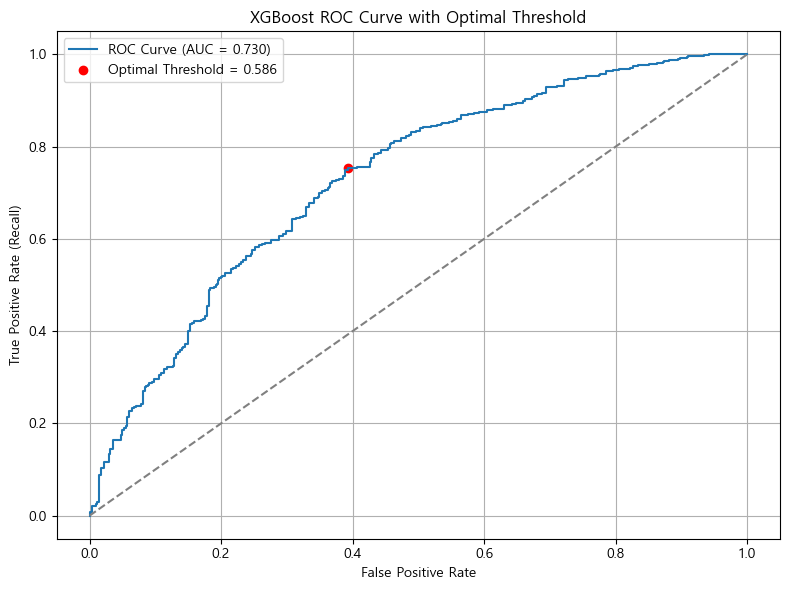

In [68]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

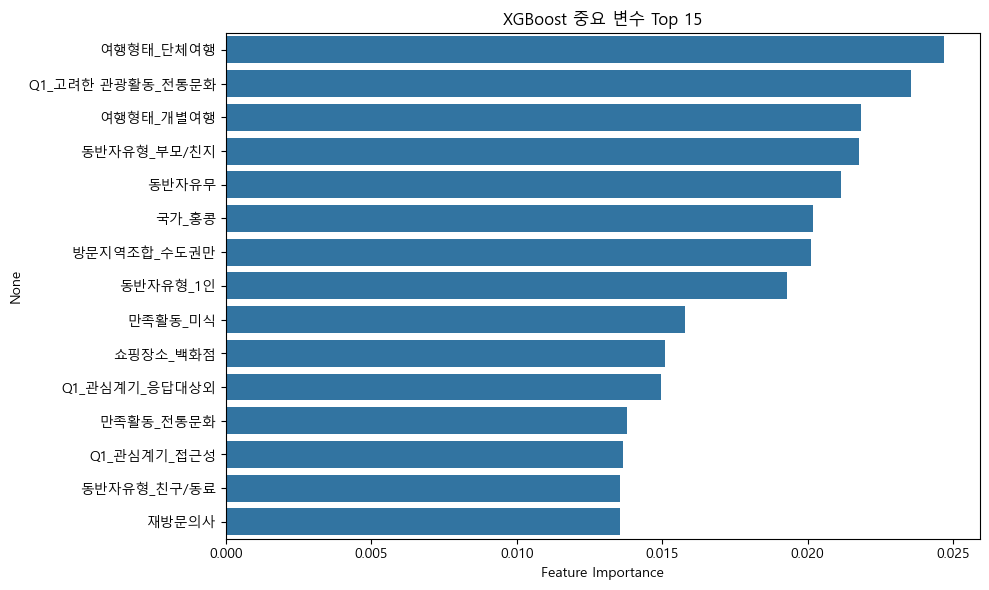

In [69]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

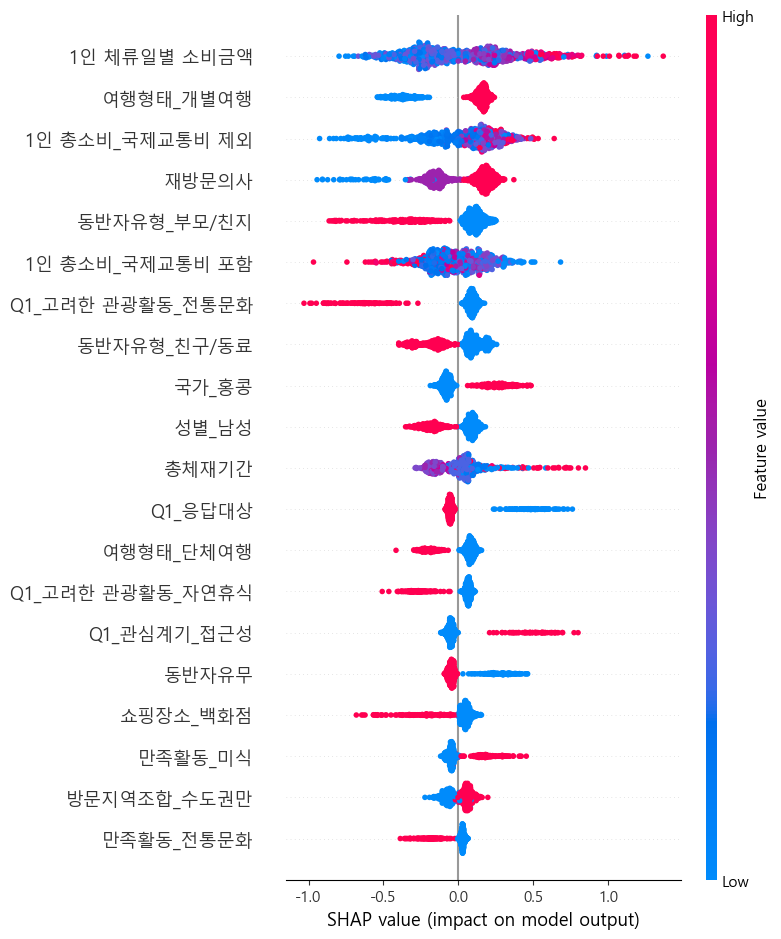

In [70]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [71]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7156774158875563, 0.7120634497504696, 0.7343921132864599, 0.722244484186293, 0.696114183215319]
▶ Mean AUC: 0.7160983292652195
▶ Std AUC : 0.012555964863310369


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [72]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.6988111834875653


In [73]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 0.6, 'subsample': 0.8}
Best AUC Score: 0.7042977621241834


In [74]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.05, 'n_estimators': 100}
Best AUC Score: 0.7128322519001972


In [75]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5}
Best AUC Score: 0.7128460545948018


In [76]:
best_model = grid_search_4.best_estimator_

In [77]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [78]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.8
colsample_bytree = 0.6
learning_rate    = 0.05
n_estimators     = 100
gamma            = 0
reg_alpha        = 0.1
reg_lambda       = 0.5


In [79]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.599]
Accuracy     : 0.702
Precision    : 0.771
Recall       : 0.726
F1 Score     : 0.748
ROC AUC      : 0.742

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.611     0.666     0.637 257736.8299999999
           1      0.771     0.726     0.748 398690.6599999995

    accuracy                          0.702 656427.4899999994
   macro avg      0.691     0.696     0.693 656427.4899999994
weighted avg      0.708     0.702     0.704 656427.4899999994


▶ [혼동 행렬]
[[195 122]
 [138 392]]


클래스별 개수:
재방문여부
1    1766
0    1055
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
1    62.6
0    37.4
Name: proportion, dtype: float64


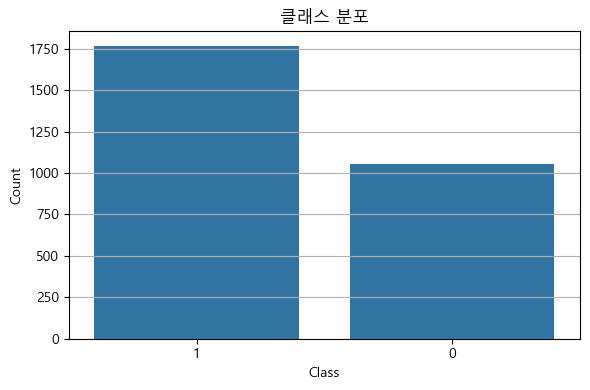

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

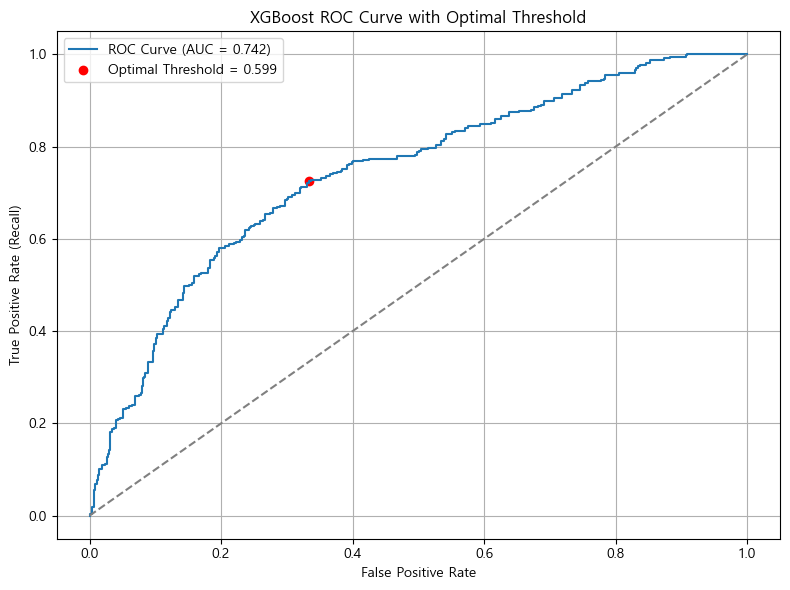

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

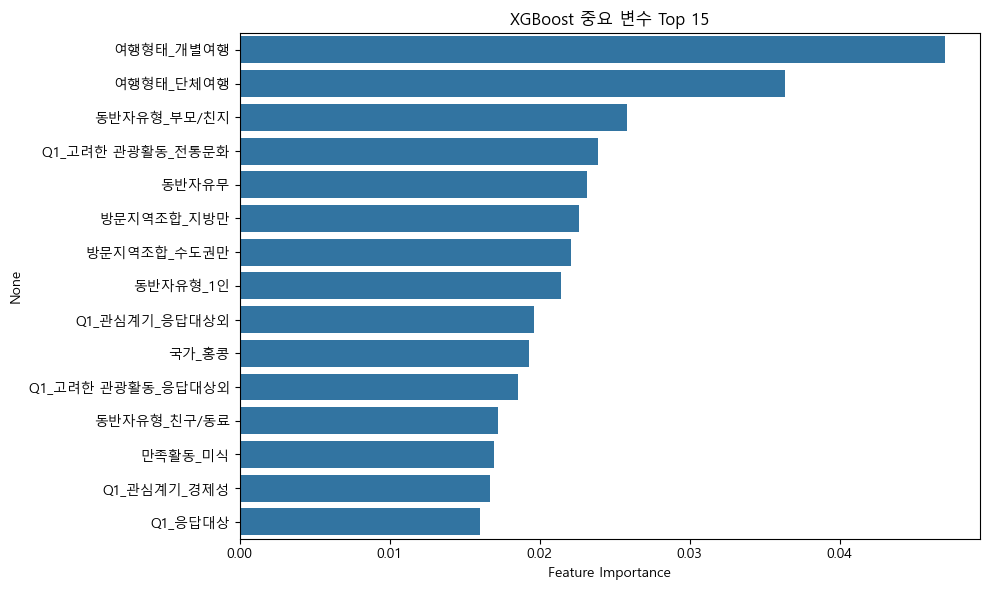

In [82]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

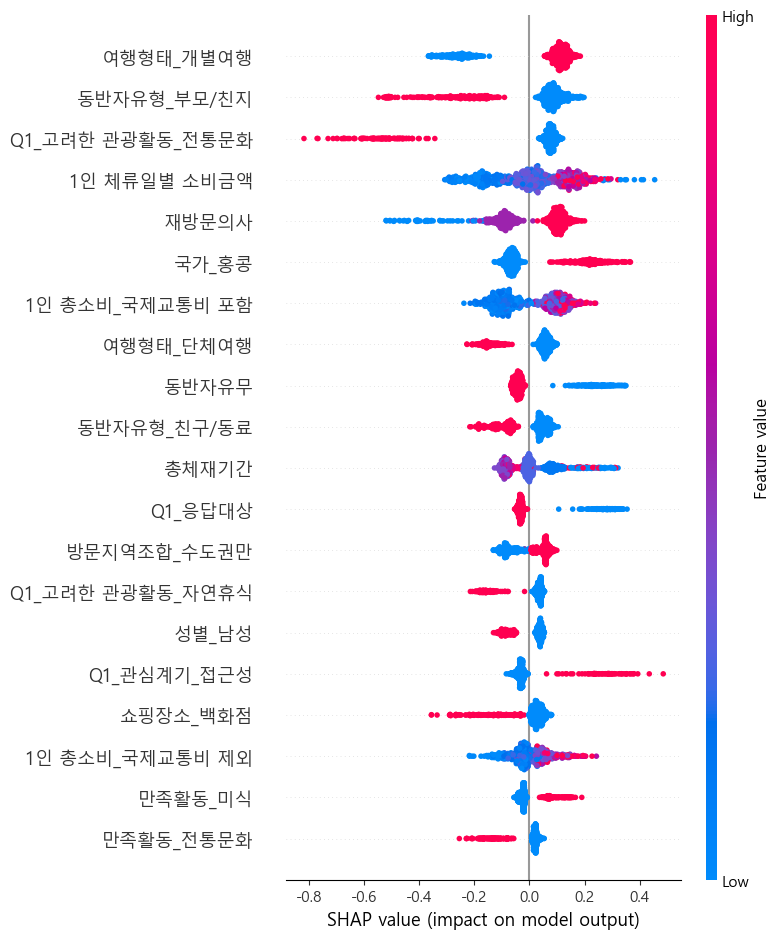

In [83]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [84]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [85]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.73815835 0.73696011 0.7317643  0.71500879 0.71404213]
▶ Mean AUC: 0.7271867368059037
▶ Std AUC: 0.010563448521599643


### Cluster1 최종 모델: 그리드 서치 모델

### (3) 시뮬레이션 - 타깃에 대해

In [86]:
# ─────────── 기본 모델 기반 시뮬레이션 ───────────
# 조건부 타깃
target_mask = (
    (y_test == 0) &
    (X_test['여행형태_개별여행'] == False) &
    (X_test['Q1_관심계기_행사'] == False) &
    (X_test['Q1_고려한 관광활동_전통문화'] == False)
)
X_target = X_test[target_mask].copy()
proba_before = model.predict_proba(X_target)[:, 1]

# 단일 선택형 변수 처리
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
# 고려한 관광활동 변수 리스트
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]


# 변수 개입 시나리오 적용
X_sim = X_target.copy()
X_sim[travel_cols] = False
X_sim['여행형태_개별여행'] = True

X_sim[interest_cols] = False
X_sim['Q1_관심계기_행사'] = True

X_sim[activity_cols] = False
X_sim['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after = model.predict_proba(X_sim)[:, 1]
delta = proba_after - proba_before #delta = After - Before는 정책 개입의 기대 효과 (확률 기준 변화량)
summary_model = pd.DataFrame({'Before': proba_before, 'After': proba_after, 'Change': delta})

#개입 후 예측 확률이 optimal_threshold를 넘으면 재방문 가능성 상승자로 간주
#“정책 개입 시 얼마나 많은 사람들이 재방문자로 바뀔 가능성이 있는가”를 판단
summary_model['Lifted'] = (summary_model['After'] >= optimal_threshold).astype(int)

# 분석 요약 출력
print("\n[기본 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_model)}")
print(f"▶ 평균 확률 변화        : {delta.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_model['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_model['Lifted'].mean() * 100:.2f}%")
# 예를 들어 재방문 확률 0.25였는데, 변수 조작 후에는 0.88로 상승
print(f"▶ 최대 변화             : {delta.max():.4f}")
# -이면 오히려 감소한 경우
print(f"▶ 최소 변화             : {delta.min():.4f}")



[기본 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 85
▶ 평균 확률 변화        : 0.1051
▶ 재방문 확률 상승자 수 : 42명
▶ 상승 비율             : 49.41%
▶ 최대 변화             : 0.5436
▶ 최소 변화             : -0.3057


In [87]:
# ─────────── 그리드서치 최적 모델 기반 시뮬레이션 ───────────
# 조건부 타깃 재사용
X_target_gs = X_test[target_mask].copy()
proba_before_gs = best_model.predict_proba(X_target_gs)[:, 1]

# 변수 개입 동일하게 적용
X_sim_gs = X_target_gs.copy()
X_sim_gs[travel_cols] = False
X_sim_gs['여행형태_개별여행'] = True

X_sim_gs[interest_cols] = False
X_sim_gs['Q1_관심계기_행사'] = True

X_sim_gs['Q1_고려한 관광활동_전통문화'] = True

# 변화 후 예측 및 요약
proba_after_gs = best_model.predict_proba(X_sim_gs)[:, 1]
delta_gs = proba_after_gs - proba_before_gs

# 전체 test 세트 기준 best_model용 threshold 계산
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_best = pd.DataFrame({'Before': proba_before_gs, 'After': proba_after_gs, 'Change': delta_gs})
summary_best['Lifted'] = (summary_best['After'] >= optimal_threshold_gs).astype(int)

# 분석 요약 출력
print("\n[그리드서치 모델 기반 시뮬레이션 결과 요약]")
print(f"▶ 타깃 수               : {len(summary_best)}")
print(f"▶ 평균 확률 변화        : {delta_gs.mean():.4f}")
print(f"▶ 재방문 확률 상승자 수 : {summary_best['Lifted'].sum()}명")
print(f"▶ 상승 비율             : {summary_best['Lifted'].mean() * 100:.2f}%")
print(f"▶ 최대 변화             : {delta_gs.max():.4f}")
print(f"▶ 최소 변화             : {delta_gs.min():.4f}")



[그리드서치 모델 기반 시뮬레이션 결과 요약]
▶ 타깃 수               : 85
▶ 평균 확률 변화        : 0.0170
▶ 재방문 확률 상승자 수 : 12명
▶ 상승 비율             : 14.12%
▶ 최대 변화             : 0.1999
▶ 최소 변화             : -0.1499


### (4) 시뮬레이션 - 전체 비재방문객에 대해

In [88]:
# ─────────── 전체 재방문X 대상: 기본 모델 ───────────

# 전체 재방문여부 = 0인 응답자
X_all = X_test.copy()
non_repeat_mask = (y_test == 0)
X_non_repeat = X_all[non_repeat_mask].copy()
proba_before_all = model.predict_proba(X_non_repeat)[:, 1]

# 단일선택형 변수 그룹
travel_cols = ['여행형태_개별여행', '여행형태_에어텔', '여행형태_단체여행']
interest_cols = [col for col in X_test.columns if col.startswith('Q1_관심계기_') and col != 'Q1_관심계기_응답대상']
activity_cols = [col for col in X_test.columns if col.startswith('Q1_고려한 관광활동_')]

# 변수 개입
X_sim_all = X_non_repeat.copy()
X_sim_all[travel_cols] = False
X_sim_all['여행형태_개별여행'] = True
X_sim_all[interest_cols] = False
X_sim_all['Q1_관심계기_행사'] = True
X_sim_all[activity_cols] = False
X_sim_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_all = model.predict_proba(X_sim_all)[:, 1]
delta_all = proba_after_all - proba_before_all

summary_all = pd.DataFrame({
    'Before': proba_before_all,
    'After': proba_after_all,
    'Change': delta_all
})
summary_all['Lifted'] = (summary_all['After'] >= optimal_threshold).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 기본 모델]")
print(f"▶ 전체 대상 수           : {len(summary_all)}")
print(f"▶ 평균 확률 변화         : {delta_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 기본 모델]
▶ 전체 대상 수           : 317
▶ 평균 확률 변화         : 0.0126
▶ 재방문 가능성 상승자 수 : 135명
▶ 상승 비율               : 42.59%
▶ 최대 변화               : 0.5436
▶ 최소 변화               : -0.3832


In [89]:
# ─────────── 전체 재방문X 대상: 그리드서치 모델 ───────────

# 대상 재사용
X_non_repeat_gs = X_test[y_test == 0].copy()
proba_before_gs_all = best_model.predict_proba(X_non_repeat_gs)[:, 1]

# 변수 개입
X_sim_gs_all = X_non_repeat_gs.copy()
X_sim_gs_all[travel_cols] = False
X_sim_gs_all['여행형태_개별여행'] = True
X_sim_gs_all[interest_cols] = False
X_sim_gs_all['Q1_관심계기_행사'] = True
X_sim_gs_all[activity_cols] = False
X_sim_gs_all['Q1_고려한 관광활동_전통문화'] = True

# 예측 및 변화량
proba_after_gs_all = best_model.predict_proba(X_sim_gs_all)[:, 1]
delta_gs_all = proba_after_gs_all - proba_before_gs_all

# best_model용 threshold 재계산 (전체 test 기준)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]
fpr_gs, tpr_gs, thresholds_gs = roc_curve(y_test, y_proba_gs, sample_weight=w_test)
optimal_idx_gs = (tpr_gs - fpr_gs).argmax()
optimal_threshold_gs = thresholds_gs[optimal_idx_gs]

summary_gs_all = pd.DataFrame({
    'Before': proba_before_gs_all,
    'After': proba_after_gs_all,
    'Change': delta_gs_all
})
summary_gs_all['Lifted'] = (summary_gs_all['After'] >= optimal_threshold_gs).astype(int)

# 결과 요약
print("\n📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]")
print(f"▶ 전체 대상 수           : {len(summary_gs_all)}")
print(f"▶ 평균 확률 변화         : {delta_gs_all.mean():.4f}")
print(f"▶ 재방문 가능성 상승자 수 : {summary_gs_all['Lifted'].sum()}명")
print(f"▶ 상승 비율               : {summary_gs_all['Lifted'].mean()*100:.2f}%")
print(f"▶ 최대 변화               : {delta_gs_all.max():.4f}")
print(f"▶ 최소 변화               : {delta_gs_all.min():.4f}")



📘 [전체 비재방문자 시뮬레이션 - 그리드서치 모델]
▶ 전체 대상 수           : 317
▶ 평균 확률 변화         : -0.0650
▶ 재방문 가능성 상승자 수 : 46명
▶ 상승 비율               : 14.51%
▶ 최대 변화               : 0.2238
▶ 최소 변화               : -0.3021


# Cluster 4

## 1. 종속변수 - 재방문 여부

### (1) 기본 모델

In [90]:
# 클러스터 국가 리스트
cluster4_countries = [
    '국가_일본', '국가_태국', '국가_몽골' 

]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster4_mask = df[cluster4_countries].any(axis=1)
df_c4 = df[cluster4_mask].copy()

In [91]:
# 종속변수
y = df_c4["재방문여부"]

# 가중치와 종속변수를 설명변수에서 제외
X = df_c4.drop(columns=["재방문여부", '가중치', 'Q1_관심계기_경험', 'Q1_관심계기_새로움'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c4["가중치"]

In [92]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, stratify=y, random_state=42
)

# 기본 모델 학습
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [93]:
# 예측값 생성
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [94]:
y_proba = model.predict_proba(X_test)[:, 1]

# 최적 threshold 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))



▶ [XGBoost 결과: Threshold = 0.701]
Accuracy     : 0.715
Precision    : 0.811
Recall       : 0.781
F1 Score     : 0.795
ROC AUC      : 0.735

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.505     0.552     0.528 301928.1200000002
           1      0.811     0.781     0.795 743330.1699999995

    accuracy                          0.715 1045258.2899999997
   macro avg      0.658     0.666     0.662 1045258.2899999997
weighted avg      0.723     0.715     0.718 1045258.2899999997


▶ [혼동 행렬]
[[136 106]
 [148 533]]


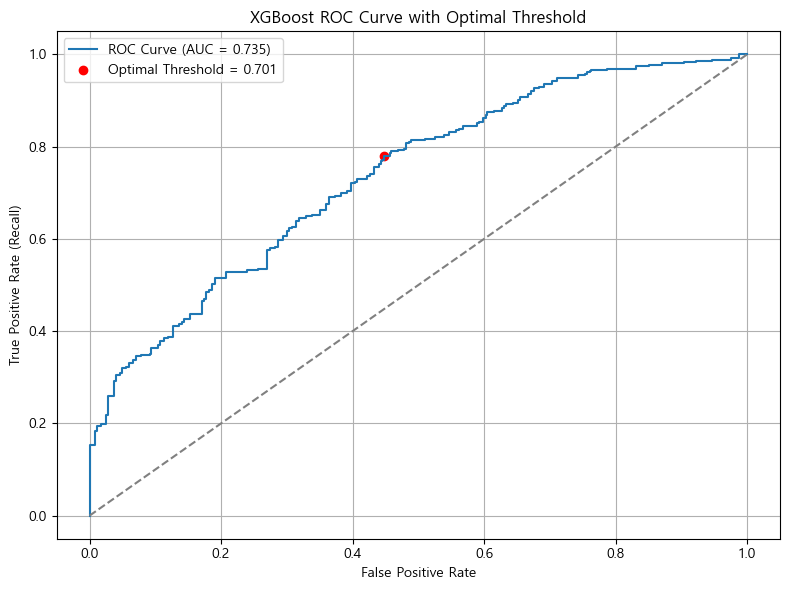

In [95]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

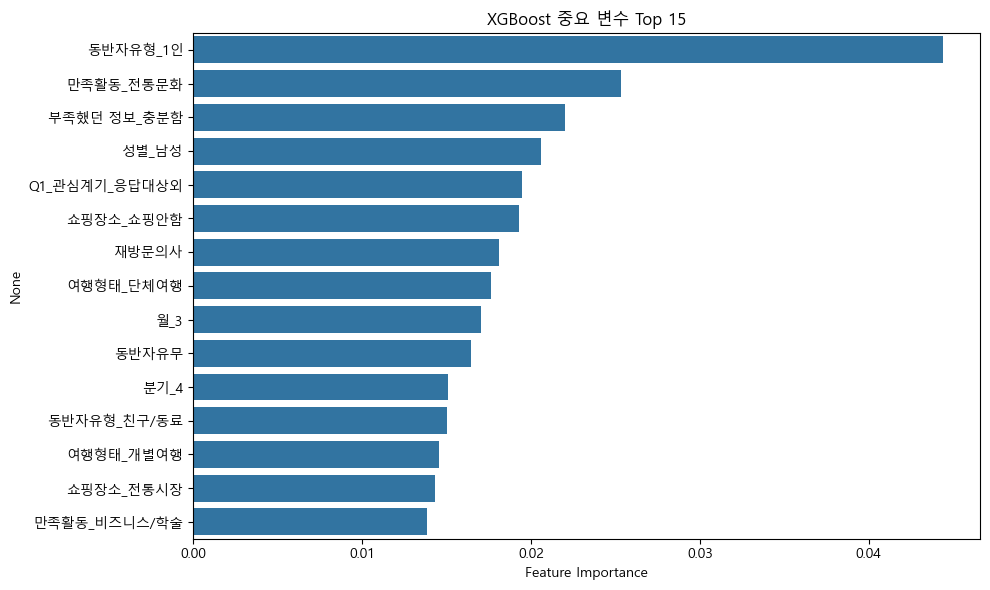

In [96]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

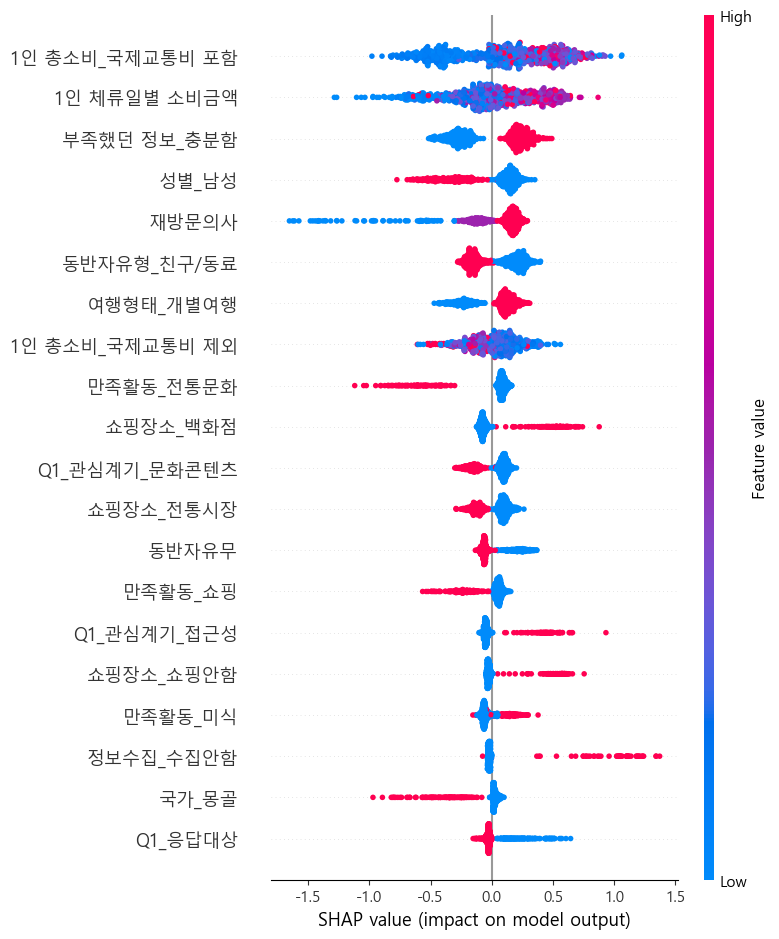

In [97]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

In [98]:
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    w_tr, w_te = weights.iloc[train_idx], weights.iloc[test_idx]

    model_cv = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model_cv.fit(X_tr, y_tr, sample_weight=w_tr)
    y_prob = model_cv.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, y_prob, sample_weight=w_te)
    auc_scores.append(auc)

print("▶ Cross-Validation AUC Scores:", auc_scores)
print("▶ Mean AUC:", np.mean(auc_scores))
print("▶ Std AUC :", np.std(auc_scores))

▶ Cross-Validation AUC Scores: [0.7361668072643766, 0.7240949607154061, 0.7836758642774847, 0.7436510876018494, 0.7312458471876587]
▶ Mean AUC: 0.7437669134093551
▶ Std AUC : 0.020948805266880876


### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명          |
| -- | ---------------------------------- | ----------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절   |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지      |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도/횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 규제 조절       |


In [99]:
# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

# 기본 모델
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_1,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best AUC Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 3, 'min_child_weight': 1}
Best AUC Score: 0.7196428971841685


In [100]:
# 1단계 결과 반영
best_model_1 = grid_search_1.best_estimator_
best_max_depth        = best_model_1.get_params()['max_depth']
best_min_child_weight = best_model_1.get_params()['min_child_weight']

# 2단계 파라미터 그리드
param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 1단계 최적값을 고정한 모델
xgb_clf_2 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    learning_rate=0.1,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_clf_2,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (2단계):", grid_search_2.best_params_)
print("Best AUC Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (2단계): {'colsample_bytree': 1.0, 'subsample': 0.6}
Best AUC Score: 0.72847245990963


In [101]:
# 2단계까지 결과 반영
best_model_2 = grid_search_2.best_estimator_
best_max_depth        = best_model_2.get_params()['max_depth']
best_min_child_weight = best_model_2.get_params()['min_child_weight']
best_subsample        = best_model_2.get_params()['subsample']
best_colsample_bytree = best_model_2.get_params()['colsample_bytree']

# 3단계 파라미터 그리드
param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 이전 최적값을 고정한 모델
xgb_clf_3 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_clf_3,
    param_grid=param_grid_3,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best AUC Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.01, 'n_estimators': 300}
Best AUC Score: 0.7422727746939461


In [102]:
# 3단계까지 결과 반영
best_model_3 = grid_search_3.best_estimator_
best_max_depth        = best_model_3.get_params()['max_depth']
best_min_child_weight = best_model_3.get_params()['min_child_weight']
best_subsample        = best_model_3.get_params()['subsample']
best_colsample_bytree = best_model_3.get_params()['colsample_bytree']
best_learning_rate    = best_model_3.get_params()['learning_rate']
best_n_estimators     = best_model_3.get_params()['n_estimators']

# 4단계 파라미터 그리드
param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# 이전 최적값을 고정한 모델
xgb_clf_4 = XGBClassifier(
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_clf_4,
    param_grid=param_grid_4,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best AUC Score:", grid_search_4.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.5}
Best AUC Score: 0.7423780225576037


In [103]:
best_model = grid_search_4.best_estimator_

In [104]:
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

In [105]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

▶ 최적 파라미터
max_depth        = 3
min_child_weight = 1
subsample        = 0.6
colsample_bytree = 1.0
learning_rate    = 0.01
n_estimators     = 300
gamma            = 0
reg_alpha        = 1.0
reg_lambda       = 1.5


In [106]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, sample_weight=w_test)
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

print(f"\n▶ [XGBoost 결과: Threshold = {optimal_threshold:.3f}]")
print(f"Accuracy     : {accuracy_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Precision    : {precision_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"Recall       : {recall_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"F1 Score     : {f1_score(y_test, y_pred_adjusted, sample_weight=w_test):.3f}")
print(f"ROC AUC      : {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f}")

print("\n▶ [분류 리포트]")
print(classification_report(y_test, y_pred_adjusted, sample_weight=w_test, digits=3))
print("\n▶ [혼동 행렬]")
print(confusion_matrix(y_test, y_pred_adjusted))


▶ [XGBoost 결과: Threshold = 0.761]
Accuracy     : 0.660
Precision    : 0.900
Recall       : 0.588
F1 Score     : 0.711
ROC AUC      : 0.780

▶ [분류 리포트]
              precision    recall  f1-score   support

           0      0.453     0.839     0.588 301928.1200000002
           1      0.900     0.588     0.711 743330.1699999995

    accuracy                          0.660 1045258.2899999997
   macro avg      0.676     0.713     0.650 1045258.2899999997
weighted avg      0.771     0.660     0.676 1045258.2899999997


▶ [혼동 행렬]
[[197  45]
 [266 415]]


클래스별 개수:
재방문여부
1    2269
0     805
Name: count, dtype: int64

클래스별 비율 (%):
재방문여부
1    73.81
0    26.19
Name: proportion, dtype: float64


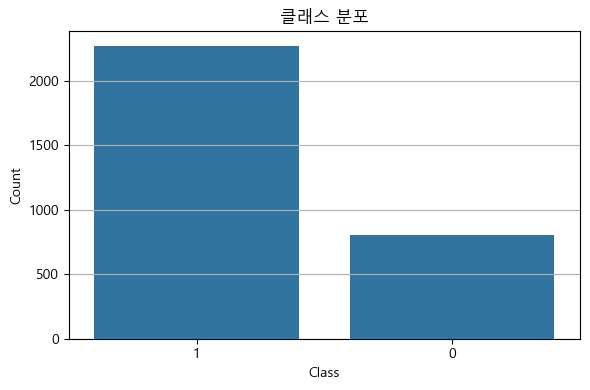

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 개수
class_counts = y.value_counts()
class_percent = y.value_counts(normalize=True) * 100

print("클래스별 개수:")
print(class_counts)
print("\n클래스별 비율 (%):")
print(class_percent.round(2))

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("클래스 분포")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

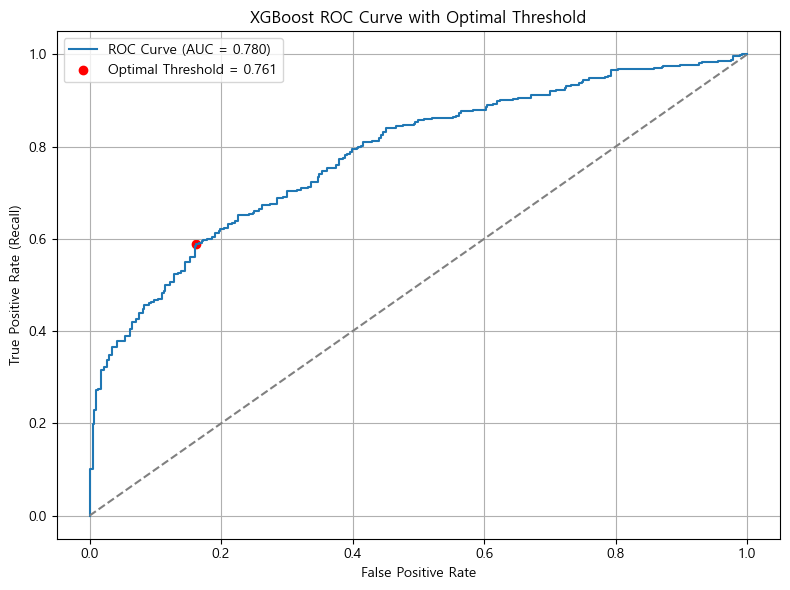

In [108]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba, sample_weight=w_test):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('XGBoost ROC Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

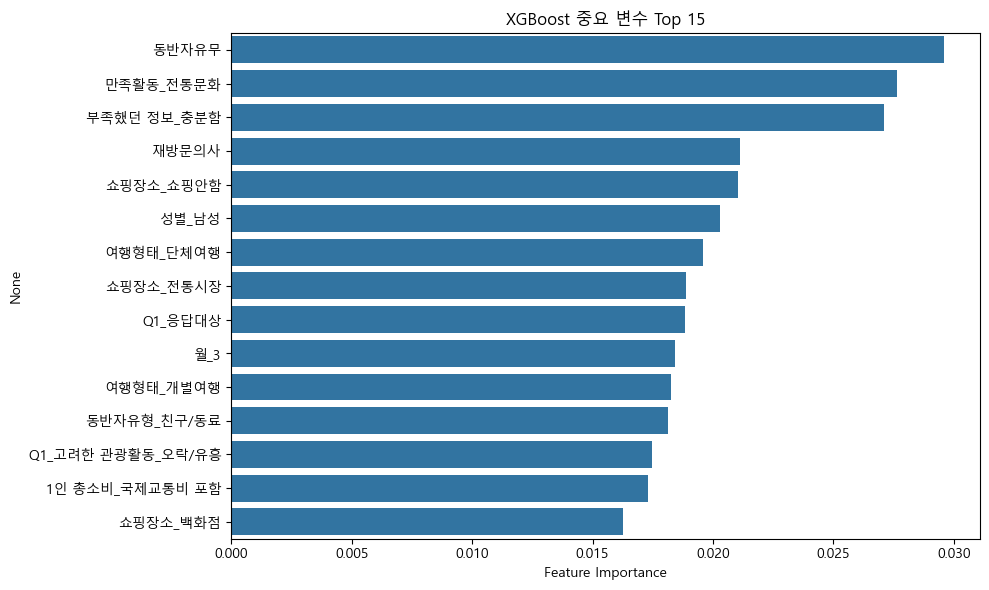

In [109]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

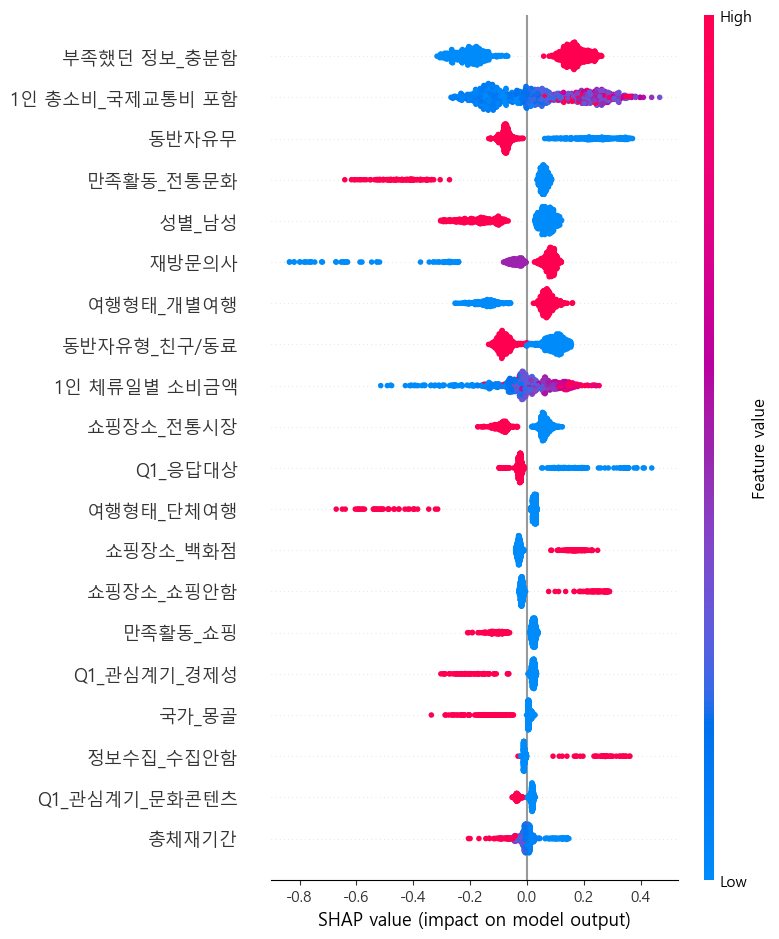

In [110]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [111]:
# 4단계 최종 모델을 그대로 사용
final_model = XGBClassifier(**best_model.get_params())

In [112]:
# StratifiedKFold 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC 기준으로 교차검증 수행
cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=cv,
    scoring='roc_auc'
)

# 결과 출력
print("▶ Cross-Validation AUC Scores:", cv_scores)
print("▶ Mean AUC:", np.mean(cv_scores))
print("▶ Std AUC:", np.std(cv_scores))

▶ Cross-Validation AUC Scores: [0.77346978 0.73581963 0.78564588 0.74658659 0.78037377]
▶ Mean AUC: 0.7643791287290351
▶ Std AUC: 0.019611030878012477


## 1. 종속변수 - 1인 총소비_국제교통비 제외

### (1) 기본 모델

In [113]:
# 클러스터 국가 리스트
cluster2_countries = [
    '국가_일본', '국가_태국', '국가_몽골' 
]

# 클러스터 국가 리스트 중 하나라도 True인 행만 필터링
cluster2_mask = df[cluster2_countries].any(axis=1)
df_c2 = df[cluster2_mask].copy()

In [114]:
# 종속변수
y_raw = df_c2['1인 총소비_국제교통비 제외']
y = np.log(y_raw)

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["1인 총소비_국제교통비 제외", '가중치', "1인 총소비_국제교통비 포함", '1인 체류일별 소비금액'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

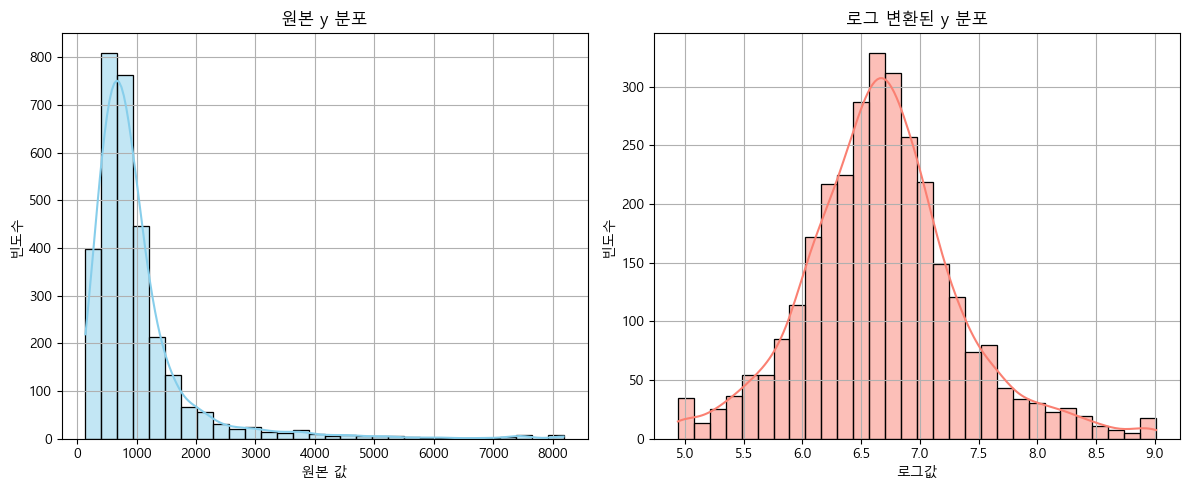

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 원본 분포
plt.subplot(1, 2, 1)
sns.histplot(y_raw, bins=30, kde=True, color='skyblue')
plt.title("원본 y 분포")
plt.xlabel("원본 값")
plt.ylabel("빈도수")
plt.grid(True)

# 로그 변환 분포
plt.subplot(1, 2, 2)
sns.histplot(y, bins=30, kde=True, color='salmon')
plt.title("로그 변환된 y 분포")
plt.xlabel("로그값")
plt.ylabel("빈도수")
plt.grid(True)

plt.tight_layout()
plt.show()


In [116]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=42
)

# 기본 모델 학습
from xgboost.sklearn import XGBRegressor
model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [117]:
# 예측값 생성
y_pred = model.predict(X_test)

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

# Adjusted R² 계산
n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"▶ RMSE : {rmse:.3f}")
print(f"▶ MAE  : {mae:.3f}")
print(f"▶ R²   : {r2:.3f}")
print(f"▶ Adjusted R²  : {adj_r2:.3f}")

▶ RMSE : 0.474
▶ MAE  : 0.341
▶ R²   : 0.419
▶ Adjusted R²  : 0.334


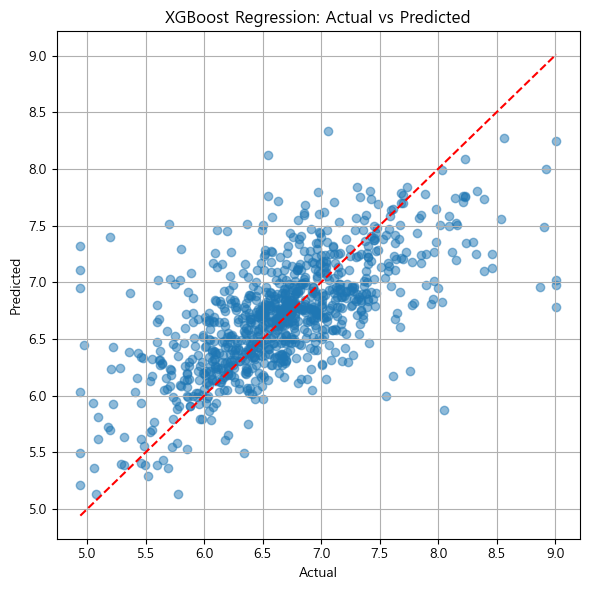

In [119]:
# 시각화: 예측 vs 실제
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring=scorer,
)

rmse_scores = (-cv_scores) ** 0.5
print("\u25b6 Cross-Validation RMSE Scores:", rmse_scores)
print("\u25b6 Mean RMSE:", np.mean(rmse_scores))
print("\u25b6 Std RMSE:", np.std(rmse_scores))

▶ Cross-Validation RMSE Scores: [0.48390249 0.51245505 0.49377189 0.43533569 0.43214056]
▶ Mean RMSE: 0.47152113443247756
▶ Std RMSE: 0.03219998549851129


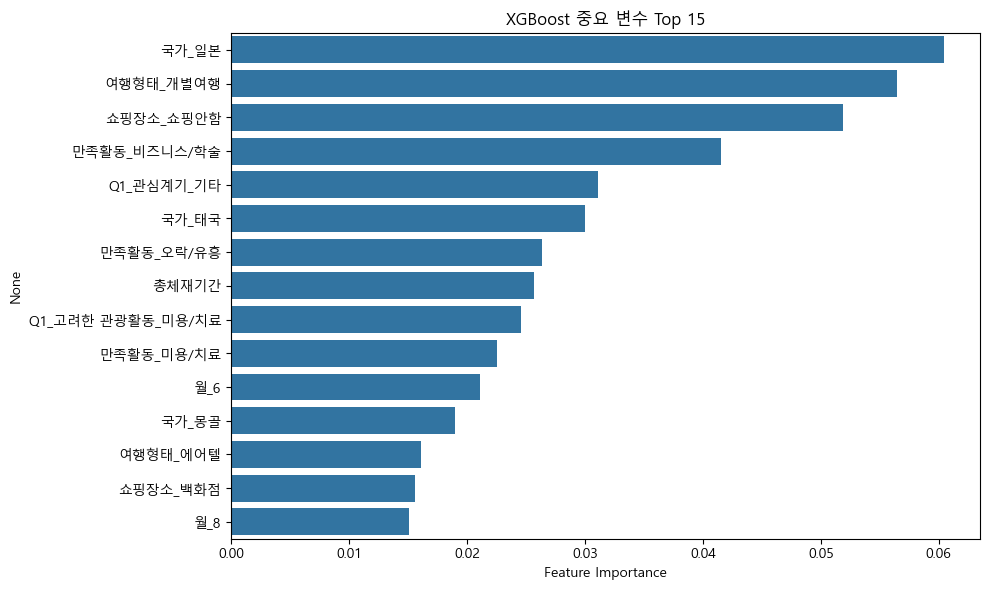

In [121]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

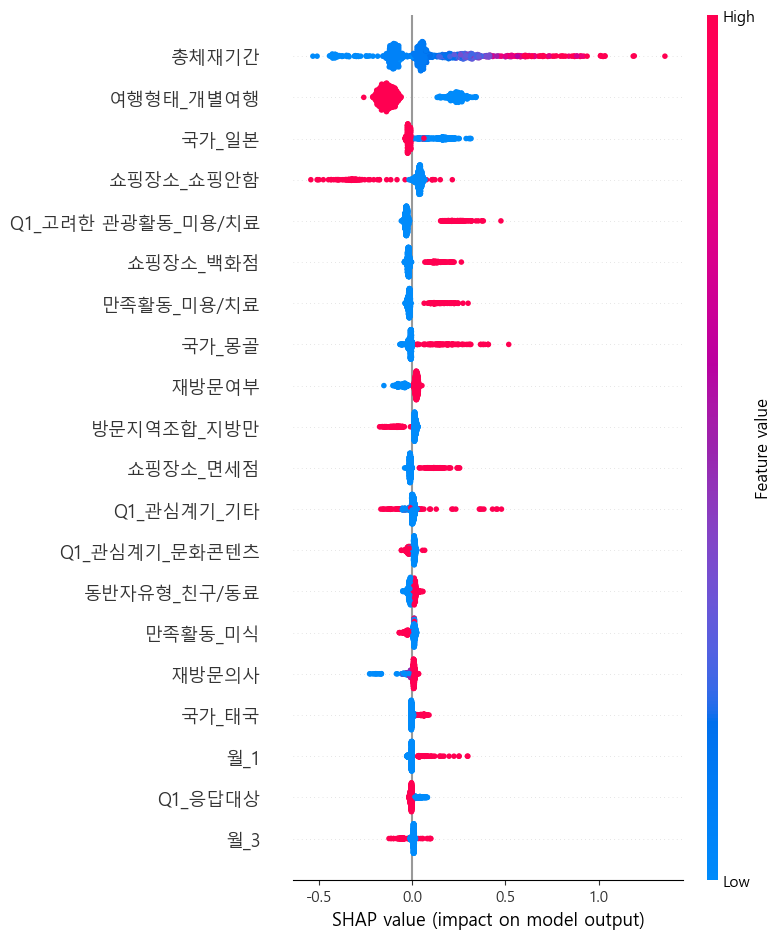

In [122]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명               |
| -- | ---------------------------------- | ---------------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절        |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지           |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도 / 반복 횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 정규화(규제) 파라미터 조정  |



In [123]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

xgb_reg_1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_reg_1,
    param_grid=param_grid_1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best Neg MSE Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 4, 'min_child_weight': 1}
Best Neg MSE Score: -0.20442652730733438


In [124]:
# 1단계 결과 반영
best_params_1 = grid_search_1.best_params_

param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_reg_2 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_reg_2,
    param_grid=param_grid_2,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_2.best_params_)
print("Best Neg MSE Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'colsample_bytree': 0.8, 'subsample': 1.0}
Best Neg MSE Score: -0.20226816826210944


In [125]:
# 2단계 결과 반영
best_params_2 = grid_search_2.best_params_

param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

xgb_reg_3 = XGBRegressor(
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    subsample=best_params_2['subsample'],
    colsample_bytree=best_params_2['colsample_bytree'],
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_reg_3,
    param_grid=param_grid_3,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best Neg MSE Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.05, 'n_estimators': 100}
Best Neg MSE Score: -0.20130436197395776


In [126]:
# 3단계 결과 반영
best_params_3 = grid_search_3.best_params_

param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

xgb_reg_4 = XGBRegressor(
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    subsample=best_params_2['subsample'],
    colsample_bytree=best_params_2['colsample_bytree'],
    learning_rate=best_params_3['learning_rate'],
    n_estimators=best_params_3['n_estimators'],
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_reg_4,
    param_grid=param_grid_4,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best Neg MSE Score:", grid_search_4.best_score_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0, 'reg_alpha': 0.1, 'reg_lambda': 2.0}
Best Neg MSE Score: -0.20101097929790135


In [127]:
best_model = grid_search_4.best_estimator_

In [128]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

# Adjusted R² 계산
n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"▶ RMSE : {rmse:.3f}")
print(f"▶ MAE  : {mae:.3f}")
print(f"▶ R²   : {r2:.3f}")
print(f"▶ Adjusted R²  : {adj_r2:.3f}")

▶ RMSE : 0.471
▶ MAE  : 0.341
▶ R²   : 0.428
▶ Adjusted R²  : 0.344


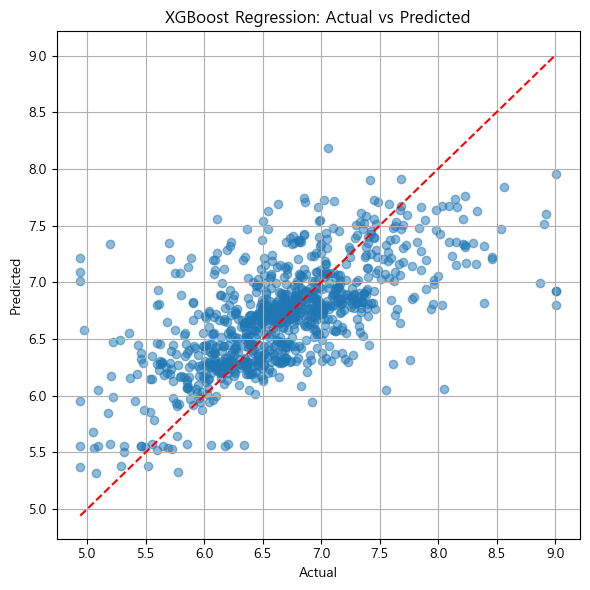

In [129]:
# 시각화: 예측 vs 실제
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적 파라미터 추출
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

# 예측 및 평가 지표 계산
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [131]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

print("\n▶ 회귀 성능 평가")
print(f"RMSE             = {rmse:.3f}")
print(f"MAE              = {mae:.3f}")
print(f"R² Score         = {r2:.3f}")
print(f"Adjusted R²      = {adj_r2:.3f}")

▶ 최적 파라미터
max_depth        = 4
min_child_weight = 1
subsample        = 1.0
colsample_bytree = 0.8
learning_rate    = 0.05
n_estimators     = 100
gamma            = 0
reg_alpha        = 0.1
reg_lambda       = 2.0

▶ 회귀 성능 평가
RMSE             = 0.471
MAE              = 0.341
R² Score         = 0.428
Adjusted R²      = 0.344


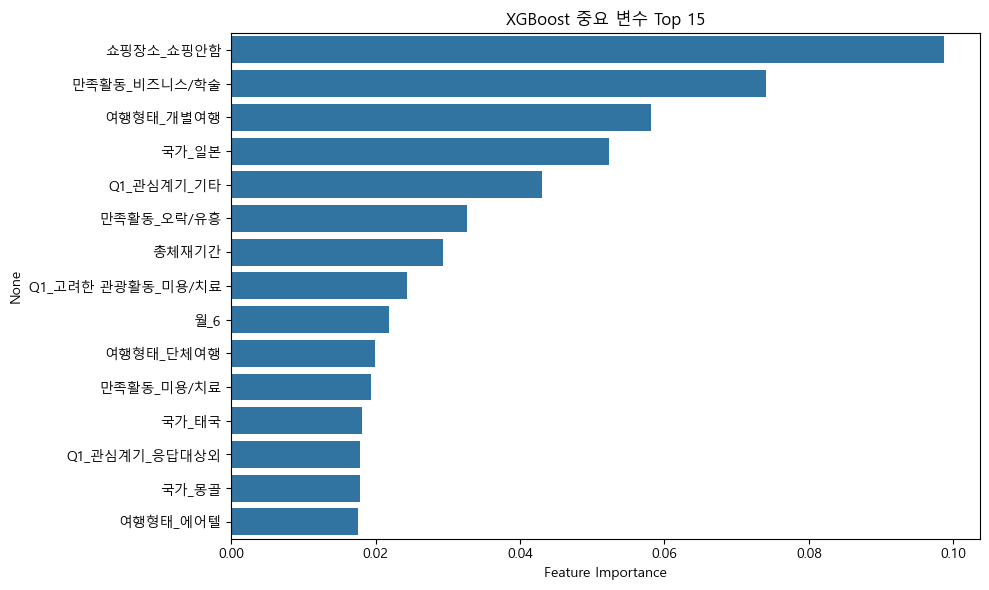

In [132]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

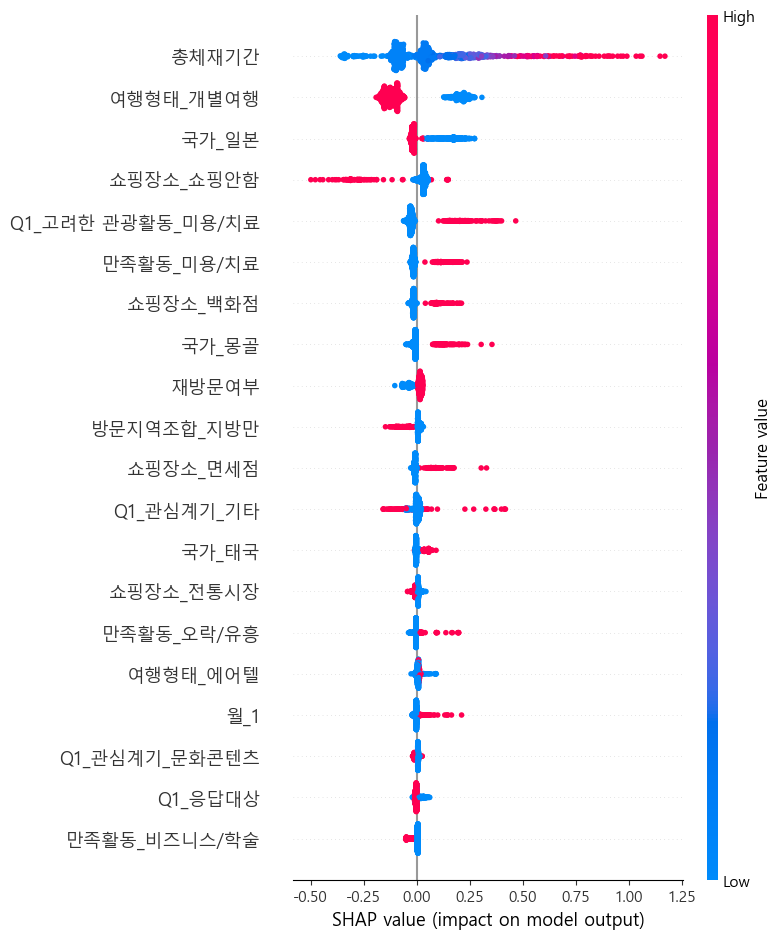

In [133]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [134]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring=scorer,
)

rmse_scores = (-cv_scores) ** 0.5
print("\u25b6 Cross-Validation RMSE Scores:", rmse_scores)
print("\u25b6 Mean RMSE:", np.mean(rmse_scores))
print("\u25b6 Std RMSE:", np.std(rmse_scores))

▶ Cross-Validation RMSE Scores: [0.48390249 0.51245505 0.49377189 0.43533569 0.43214056]
▶ Mean RMSE: 0.47152113443247756
▶ Std RMSE: 0.03219998549851129


## 2. 종속변수 - 1인 체류일별 소비금액

### (1) 기본 모델

In [135]:
# 종속변수
y_raw = df_c2['1인 체류일별 소비금액']
y = np.log(y_raw)

# 가중치와 종속변수를 설명변수에서 제외
X = df_c2.drop(columns=["1인 총소비_국제교통비 제외", '가중치', "1인 총소비_국제교통비 포함", '1인 체류일별 소비금액'])

# 문자열인 열은 설명변수에서 제외
X = X.select_dtypes(exclude=['object'])

weights = df_c2["가중치"]

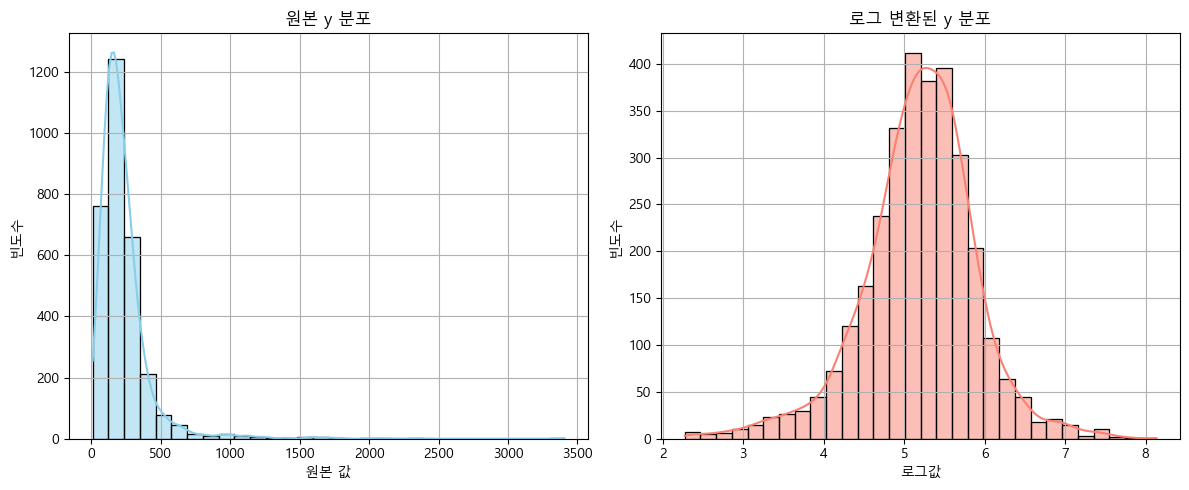

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 원본 분포
plt.subplot(1, 2, 1)
sns.histplot(y_raw, bins=30, kde=True, color='skyblue')
plt.title("원본 y 분포")
plt.xlabel("원본 값")
plt.ylabel("빈도수")
plt.grid(True)

# 로그 변환 분포
plt.subplot(1, 2, 2)
sns.histplot(y, bins=30, kde=True, color='salmon')
plt.title("로그 변환된 y 분포")
plt.xlabel("로그값")
plt.ylabel("빈도수")
plt.grid(True)

plt.tight_layout()
plt.show()


In [137]:
# train / test 세트 분리
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=42
)

# 기본 모델 학습
from xgboost.sklearn import XGBRegressor
model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=w_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [138]:
# 예측값 생성
y_pred = model.predict(X_test)

In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

# Adjusted R² 계산
n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"▶ RMSE : {rmse:.3f}")
print(f"▶ MAE  : {mae:.3f}")
print(f"▶ R²   : {r2:.3f}")
print(f"▶ Adjusted R²  : {adj_r2:.3f}")

▶ RMSE : 0.473
▶ MAE  : 0.341
▶ R²   : 0.474
▶ Adjusted R²  : 0.396


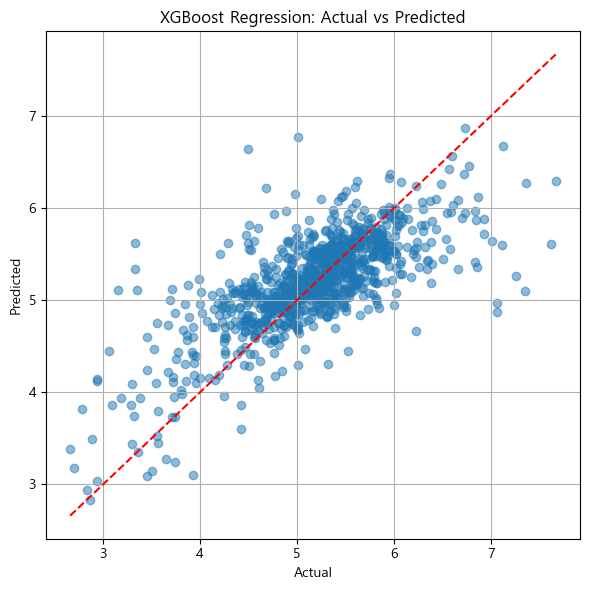

In [140]:
# 시각화: 예측 vs 실제
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [141]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring=scorer,
)

rmse_scores = (-cv_scores) ** 0.5
print("\u25b6 Cross-Validation RMSE Scores:", rmse_scores)
print("\u25b6 Mean RMSE:", np.mean(rmse_scores))
print("\u25b6 Std RMSE:", np.std(rmse_scores))

▶ Cross-Validation RMSE Scores: [0.48020071 0.51054934 0.48856102 0.43393078 0.43662632]
▶ Mean RMSE: 0.46997363279797444
▶ Std RMSE: 0.030025329778503793


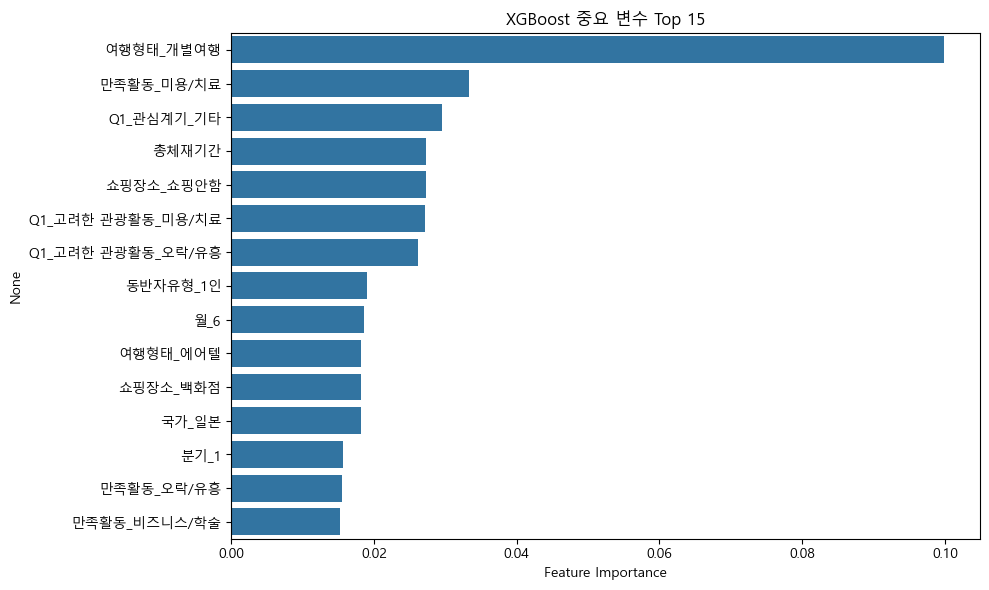

In [142]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

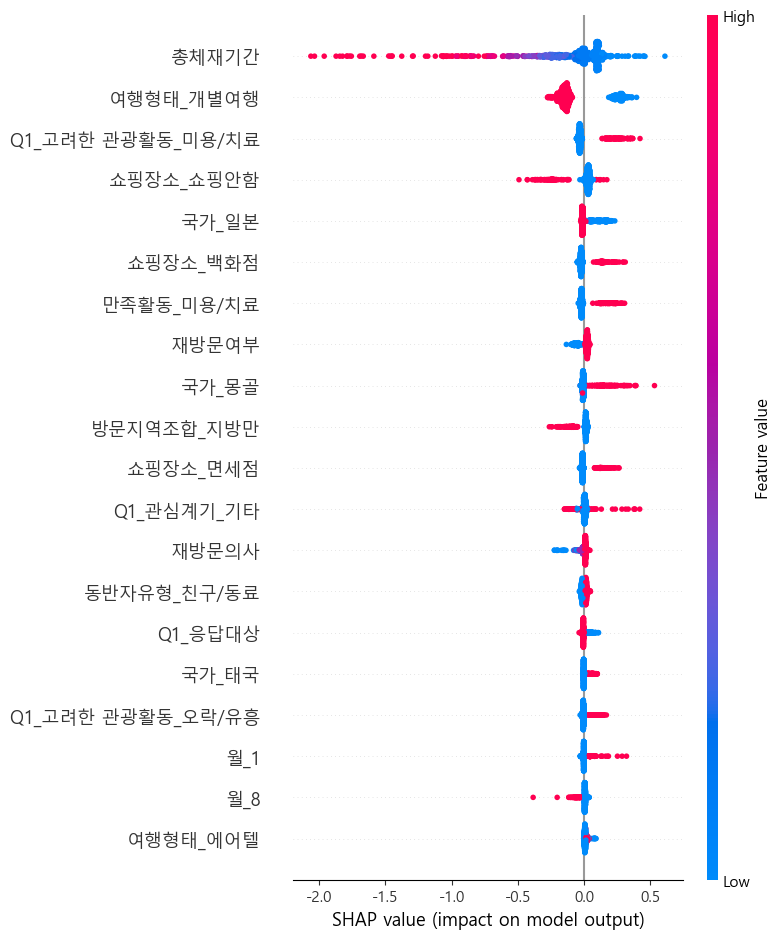

In [143]:
explainer = shap.Explainer(model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test, plot_type="dot")

### (2) 그리드 서치 모델

| 단계 | 파라미터                               | 설명               |
| -- | ---------------------------------- | ---------------- |
| ①  | `max_depth`, `min_child_weight`    | 모델 복잡도 조절        |
| ②  | `subsample`, `colsample_bytree`    | 과적합 방지           |
| ③  | `learning_rate`, `n_estimators`    | 학습 속도 / 반복 횟수 조절 |
| ④  | `gamma`, `reg_alpha`, `reg_lambda` | 정규화(규제) 파라미터 조정  |



In [144]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# 1단계 파라미터 그리드
param_grid_1 = {
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5]
}

xgb_reg_1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    random_state=42
)

grid_search_1 = GridSearchCV(
    estimator=xgb_reg_1,
    param_grid=param_grid_1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_1.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_1.best_params_)
print("Best Neg MSE Score:", grid_search_1.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 5, 'min_child_weight': 1}
Best Neg MSE Score: -0.20582336304549576


In [145]:
# 1단계 결과 반영
best_params_1 = grid_search_1.best_params_

param_grid_2 = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_reg_2 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    random_state=42
)

grid_search_2 = GridSearchCV(
    estimator=xgb_reg_2,
    param_grid=param_grid_2,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_2.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters:", grid_search_2.best_params_)
print("Best Neg MSE Score:", grid_search_2.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'colsample_bytree': 0.8, 'subsample': 1.0}
Best Neg MSE Score: -0.2054161387607889


In [146]:
# 2단계 결과 반영
best_params_2 = grid_search_2.best_params_

param_grid_3 = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

xgb_reg_3 = XGBRegressor(
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    subsample=best_params_2['subsample'],
    colsample_bytree=best_params_2['colsample_bytree'],
    random_state=42
)

grid_search_3 = GridSearchCV(
    estimator=xgb_reg_3,
    param_grid=param_grid_3,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_3.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (3단계):", grid_search_3.best_params_)
print("Best Neg MSE Score:", grid_search_3.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters (3단계): {'learning_rate': 0.05, 'n_estimators': 100}
Best Neg MSE Score: -0.2050566584489931


In [147]:
# 3단계 결과 반영
best_params_3 = grid_search_3.best_params_

param_grid_4 = {
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

xgb_reg_4 = XGBRegressor(
    max_depth=best_params_1['max_depth'],
    min_child_weight=best_params_1['min_child_weight'],
    subsample=best_params_2['subsample'],
    colsample_bytree=best_params_2['colsample_bytree'],
    learning_rate=best_params_3['learning_rate'],
    n_estimators=best_params_3['n_estimators'],
    random_state=42
)

grid_search_4 = GridSearchCV(
    estimator=xgb_reg_4,
    param_grid=param_grid_4,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_4.fit(X_train, y_train, sample_weight=w_train)

print("Best Parameters (4단계):", grid_search_4.best_params_)
print("Best Neg MSE Score:", grid_search_4.best_score_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters (4단계): {'gamma': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5}
Best Neg MSE Score: -0.20361127611872268


In [148]:
best_model = grid_search_4.best_estimator_

In [149]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

# Adjusted R² 계산
n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"▶ RMSE : {rmse:.3f}")
print(f"▶ MAE  : {mae:.3f}")
print(f"▶ R²   : {r2:.3f}")
print(f"▶ Adjusted R²  : {adj_r2:.3f}")

▶ RMSE : 0.475
▶ MAE  : 0.344
▶ R²   : 0.468
▶ Adjusted R²  : 0.390


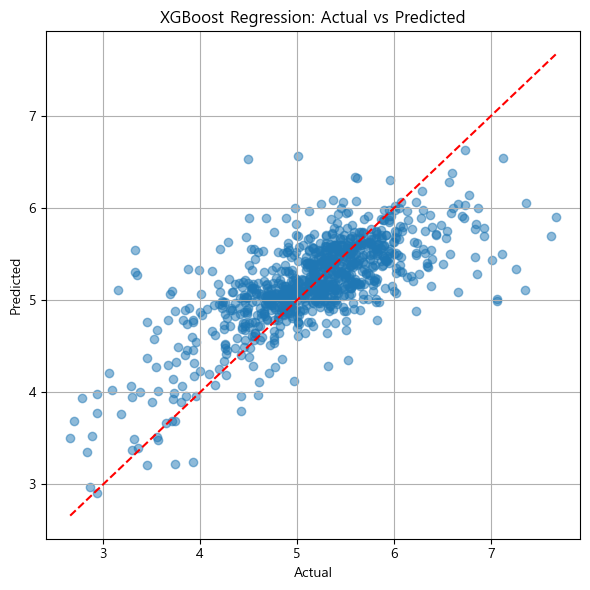

In [150]:
# 시각화: 예측 vs 실제
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [151]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 최적 파라미터 추출
best_params_4 = grid_search_4.best_params_

best_max_depth        = best_model.get_params()['max_depth']
best_min_child_weight = best_model.get_params()['min_child_weight']
best_subsample        = best_model.get_params()['subsample']
best_colsample_bytree = best_model.get_params()['colsample_bytree']
best_learning_rate    = best_model.get_params()['learning_rate']
best_n_estimators     = best_model.get_params()['n_estimators']
best_gamma            = best_params_4.get('gamma', 0)
best_reg_alpha        = best_params_4.get('reg_alpha', 0)
best_reg_lambda       = best_params_4.get('reg_lambda', 1)

# 예측 및 평가 지표 계산
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, sample_weight=w_test)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred, sample_weight=w_test)
r2 = r2_score(y_test, y_pred, sample_weight=w_test)

n = X_test.shape[0]  # 관측치 수
p = X_test.shape[1]  # 설명변수 수
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [152]:
print("▶ 최적 파라미터")
print(f"max_depth        = {best_max_depth}")
print(f"min_child_weight = {best_min_child_weight}")
print(f"subsample        = {best_subsample}")
print(f"colsample_bytree = {best_colsample_bytree}")
print(f"learning_rate    = {best_learning_rate}")
print(f"n_estimators     = {best_n_estimators}")
print(f"gamma            = {best_gamma}")
print(f"reg_alpha        = {best_reg_alpha}")
print(f"reg_lambda       = {best_reg_lambda}")

print("\n▶ 회귀 성능 평가")
print(f"RMSE             = {rmse:.3f}")
print(f"MAE              = {mae:.3f}")
print(f"R² Score         = {r2:.3f}")
print(f"Adjusted R²      = {adj_r2:.3f}")

▶ 최적 파라미터
max_depth        = 5
min_child_weight = 1
subsample        = 1.0
colsample_bytree = 0.8
learning_rate    = 0.05
n_estimators     = 100
gamma            = 0.5
reg_alpha        = 0
reg_lambda       = 0.5

▶ 회귀 성능 평가
RMSE             = 0.475
MAE              = 0.344
R² Score         = 0.468
Adjusted R²      = 0.390


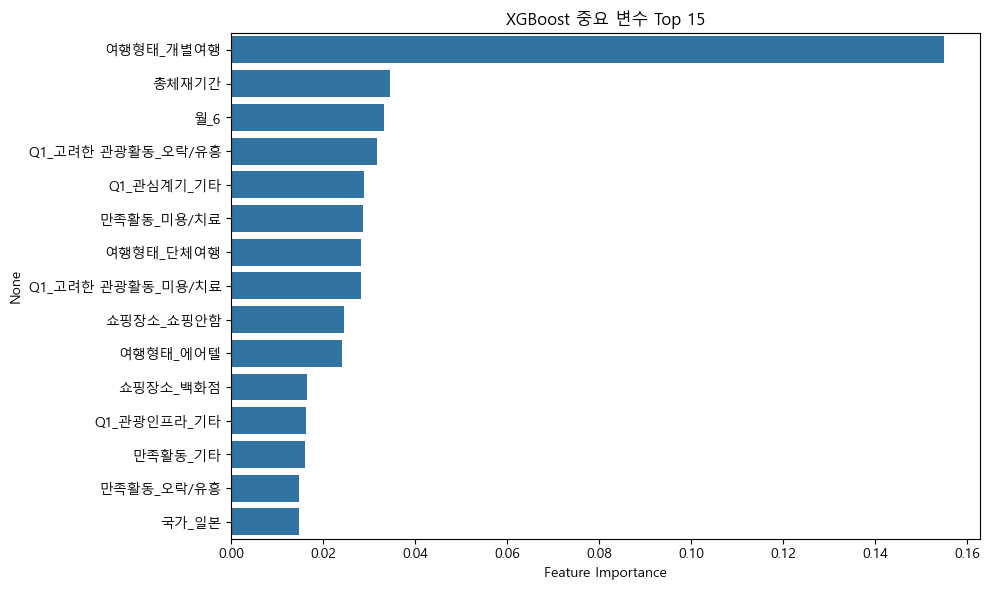

In [153]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title(f'XGBoost 중요 변수 Top {top_n}')
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

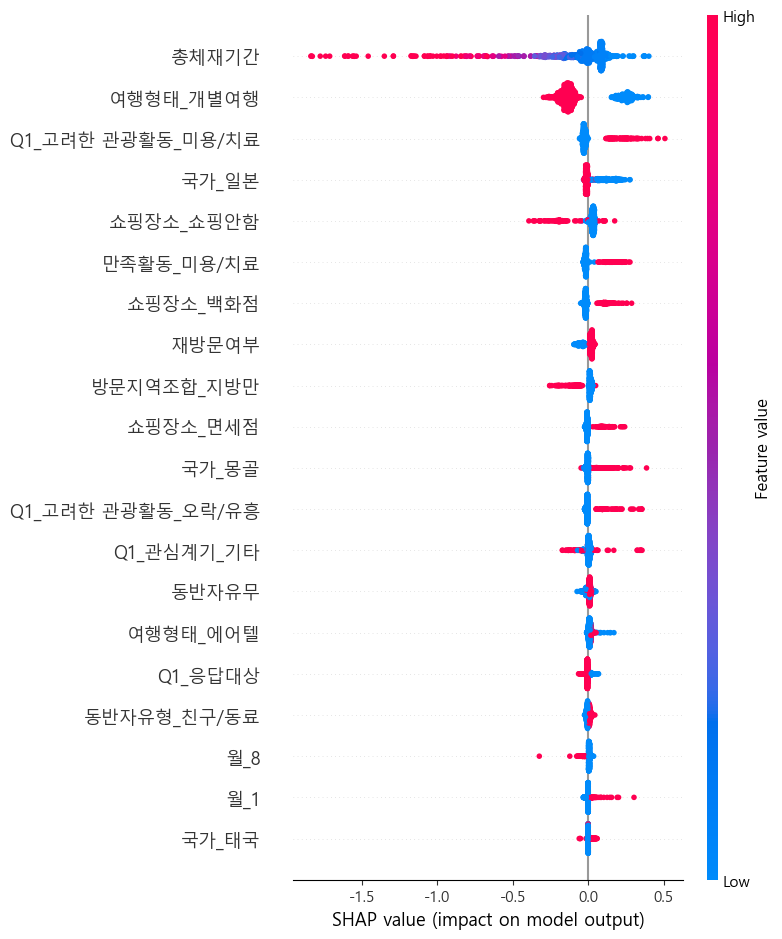

In [154]:
explainer = shap.Explainer(best_model)

# test 세트에 대한 SHAP 값 계산
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="dot")

In [155]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=cv,
    scoring=scorer,
)

rmse_scores = (-cv_scores) ** 0.5
print("\u25b6 Cross-Validation RMSE Scores:", rmse_scores)
print("\u25b6 Mean RMSE:", np.mean(rmse_scores))
print("\u25b6 Std RMSE:", np.std(rmse_scores))

▶ Cross-Validation RMSE Scores: [0.48020071 0.51054934 0.48856102 0.43393078 0.43662632]
▶ Mean RMSE: 0.46997363279797444
▶ Std RMSE: 0.030025329778503793
